# Neural Networks: Building Blocks

In [2]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
from jax import grad, jit
from matplotlib.animation import FuncAnimation
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from torch import nn
from typing import List, Callable

mpl.rcParams['mathtext.fontset']='cm'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from keras.datasets import mnist

set_matplotlib_formats("retina")

## A Single Neuron

Neurons are at the core of artificial neural networks. Like the networks they form, they are inspired by their biological counterparts but are not models of them.

A neuron weighs its inputs separately and passes their sum through an activation function. The result of this operation is the neuron's ***activation***. Typically, a bias is added to the weighted sum of the inputs to allow a left- or rightward shift of the activation function.

$$y = σ(w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + ... + w_{n}x_{n} + b)$$

$$y = σ(\sum\limits_{i=1}^n w_{i}x_{i} + b)$$

where the neuron's activation $y$ is determined by a sigmoid activation function $σ$, the neuron's weights $w_{n}$, its inputs $x_{n}$, and a bias $b$.

<p align="center">
    <img src="assets/perceptron.svg" width=40% alt="A single neuron"/>
</p>

The weights and inputs can be represented as tensors and the weighted sum can be therefore computed as a dot product between the weight tensor $w$ and the input tensor $x$. 

$$y = \sigma(w \cdot x  + b)$$

One advantage of computing the weighted sum as a dot product is that we can leverage efficient, highly-parallelized libraries such as CUDA or BLAS (Basic Linear Algebra Subprograms) implementations.

In [247]:
weights = np.array([0.1, 0.2, 0.3])
input = np.array([0.2, 0.3, 0.1])
bias = 1

sum([w * x for w, x in zip(weights, input)]) + bias

1.11

In [252]:
np.dot(input, weights) + bias

1.11

The operation of calculating the output of a neural network based on some input is called a ***forward pass*** or, more generally, ***forward propagation***.

In [95]:
class Neuron():

    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias

    def forward(self, input):
        """A forward pass through the neuron"""
        z = np.dot(self.weights, input) + self.bias
        print(f"Weighted sum = {z}")
        # Sigmoid activation function
        y = 1 / (1 + math.exp(-z))
        return y

neuron = Neuron(weights, bias)
print(f"Activation = {neuron.forward(input)}")

Weighted sum = [[1.11]]
Activation = 0.7521291114395702


*Note*: Neural networks consisting of a single neuron date back to the 1950s. The ***perceptron***, a machine learning algortihm used for binary classification, effectively consists of a single neuron using a [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) as its activation function.

### Activation Functions

Activation functions are analogous to the action potential in biological neurons. The activation function determines whether a neuron activates and to what extent.

Activation functions allow neural networks to *learn layered representations of the input data* and *account for non-linear relationships*.

If the output of a neuron were the weighted sum of its inputs, neural networks would simply represent a linear function. Even deep neural networks with several layers could be reduced to a linear function of their input. Linear hyperplanes (constant decision boundaries) are limited representations that are unable to capture nonlinear features.

<div align="center">
    <div style="width: 60%; display: flex; justify-content: center; flex-flow: row nowrap; align-items: center;">
        <div style="padding: 2%; width: 47.5%; height: 100%;">
            <img src="assets/moons_logits_3d.png" style="max-width: 100%; max-height: 100%;">
        </div>
        <div style="padding: 2%; width: 52.5%; height: 100%;">
            <img src="assets/moons_logits.png" style="max-width: 100%; max-height: 100%;">
        </div>
    </div>
</div>

The decision surface illustrated above is that of a model with ReLU and Sigmoid activation functions and that achieves an accuracy of 91.25% on the training data. In contrast, a model without nonlinear activation functions is only able to learn a linear decision surface, as illustrated below. The linear model achieves an accuracy of 83.25%.

<div align="center">
    <div style="width: 60%; display: flex; justify-content: center; flex-flow: row nowrap; align-items: center;">
        <div style="padding: 2%; width: 47.5%; height: 100%;">
            <img src="assets/moons_linear_3d.png" style="max-width: 100%; max-height: 100%;">
        </div>
        <div style="padding: 2%; width: 52.5%; height: 100%;">
            <img src="assets/moons_linear.png" style="max-width: 100%; max-height: 100%;">
        </div>
    </div>
</div>

#### **Sigmoid**

Sigmoid (also known as logistic function) is a non-linear, continuously differentiable, monotonic activation function. It has a fixed range $(0,1)$. One of the issues of sigmoid is that it susceptible to the ***vanishing gradient problem***.

$$sigmoid(z) = \dfrac{1}{1 + e^{-z}}$$

$$sigmoid'(z) = sigmoid(z)(1-sigmoid(z))$$

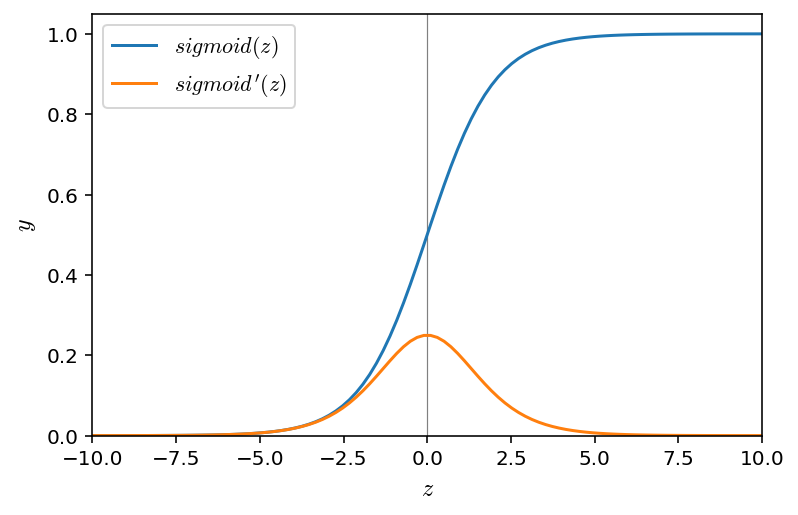

In [3]:
def sigmoid(z, derivative=False):
    """Sigmoid activation function"""
    if derivative:
        return sigmoid(z) * (1 - sigmoid(z))
    return 1 / (1 + np.exp(-z))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(0, linewidth=0.6, color="grey")
ax.set_aspect(12)
z = np.linspace(-10, 10, 100)
plt.plot(z, sigmoid(z), label=r"$sigmoid(z)$")
plt.plot(z, sigmoid(z, derivative=True), label=r"$sigmoid'(z)$")
plt.xlim(xmin=-10, xmax=10)
plt.ylim(ymin=0)
ax.set_xlabel(r"$z$", fontsize=12)
ax.set_ylabel(r"$y$", fontsize=12)
plt.legend(prop={"size": 11})
plt.savefig("assets/sigmoid.png", dpi=200, bbox_inches='tight')
plt.show()

#### **Tanh**

Tanh is a non-linear, continuously differentiable activation function that comes from the same family of functions as sigmoid. However, tanh is *zero-centered*, meaning that the average of its inputs is zero. Zero-centered inputs and activations have been shown to improve the convergence of neural networks during training (see [Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf ) by LeCun et al.). Tanh is therefore often preferred to sigmoid, even though it also suffers from the vanishing gradient problem.

$$tanh(z) = \dfrac{e^z - e^{-z}}{e^z + e^{-z}}$$

$$tanh'(z) = 1 - tanh(z)^2$$

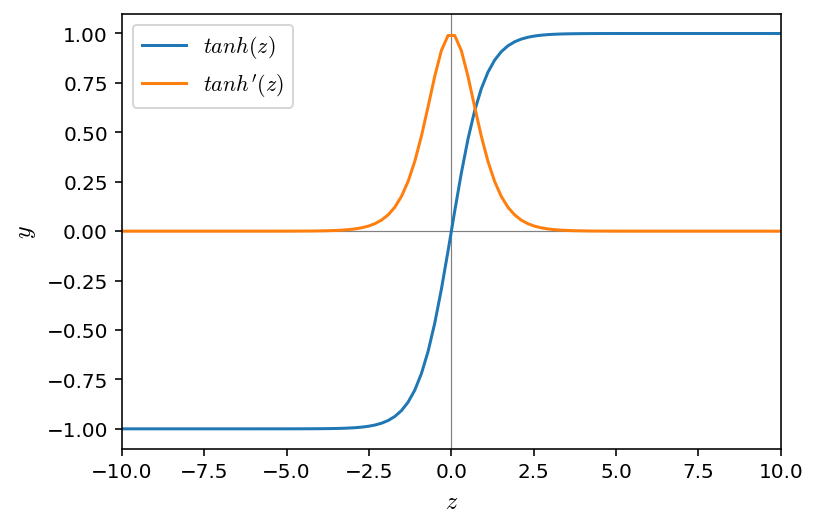

In [211]:
def tanh(z, derivative=False):
    """Tanh activation function"""
    if derivative:
        return 1 - np.power(tanh(z), 2)
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))    

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(0, linewidth=0.6, color="grey")
ax.axhline(0, linewidth=0.6, color="grey")
ax.set_aspect(6)
z = np.linspace(-10, 10, 100)
plt.plot(z, tanh(z), label=r"$tanh(z)$")
plt.plot(z, tanh(z, derivative=True), label=r"$tanh'(z)$")
plt.xlim(xmin=-10, xmax=10)
ax.set_xlabel(r"$z$", fontsize=12)
ax.set_ylabel(r"$y$", fontsize=12)
plt.legend(prop={"size": 11})
plt.savefig("assets/tanh.png", dpi=200, bbox_inches='tight')
plt.show()

#### **Rectified Linear Unit (ReLU)**

ReLU is a non-linear activation function with a range $[0, ∞)$. ReLU is less computionally expensive than other activation functions because it involves simpler mathemtical operations, and therefore allows for faster training. Moreover neural networks using ReLU benefit from ***sparse activation***: not all neurons in a hidden are activated (activation > 0). However, ReLU neurons can suffer from the ***dying ReLU problem***.

$$ReLU(x) = max(0, x)$$

$$
ReLU'(x)=
\begin{cases} 
0 & \text{if  }  x < 0 \\
1 & \text{if  }  x > 0 \\
\end{cases}
$$

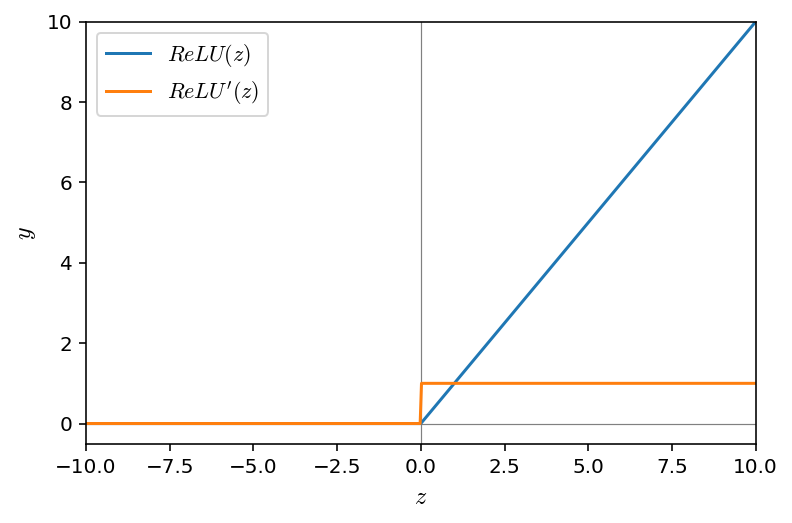

In [24]:
def relu(z, derivative=False):
    """ReLU activation function"""
    if derivative:
        return (z > 0) * 1
    return np.maximum(0, z)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(0, linewidth=0.6, color="grey")
ax.axhline(0, linewidth=0.6, color="grey")
ax.set_aspect(1.2)
z = np.linspace(-10, 10, 500)
plt.plot(z, relu(z), label=r"$ReLU(z)$")
plt.plot(z, relu(z, derivative=True), label=r"$ReLU'(z)$")
plt.xlim(xmin=-10, xmax=10)
plt.ylim(ymax=10)
ax.set_xlabel(r"$z$", fontsize=12)
ax.set_ylabel(r"$y$", fontsize=12)
plt.legend(prop={"size": 11})
plt.savefig("assets/relu.png", dpi=200, bbox_inches='tight')
plt.show()

## A Network of Neurons

### Layers

A single neuron can only extract a limited representation on its own. In neural networks, neurons are therefore aggregated into connected ***layers***. Layers extract *representations* out of the data fed into them and, chained together, *progressively distillate the data*.

All weights in a layer can be represented as a matrix $W$ with $k$ neurons that each have $n$ weights. The sums of the weighted inputs of all neurons in the $n$-th layer can be calculated as a the matrix vector product between the weights matrix and the vector $a^{(n-1)}$ of the activations of the previous layer. The activation vector $a^{(n)}$ of the $n$-th layer is then the sum of the weighted inputs vector and the bias vector $b$, passed through an activation function.

$$
a^{(n)} = σ
\begin{pmatrix}
\begin{bmatrix}
w_{0,0} & w_{0,1} & \dots & w_{0,n} \\
w_{1,0} & w_{1,1} & \dots & w_{1,n} \\
\vdots  & \vdots  & \ddots & \vdots \\
w_{k,0} & w_{k,1} & \dots & w_{k,n} \\
\end{bmatrix}
\begin{bmatrix}
a_{0}^{(n-1)} \\
a_{1}^{(n-1)} \\
\vdots    \\
a_{n}^{(n-1)} \\
\end{bmatrix}
+
\begin{bmatrix}
b_{0} \\
b_{1} \\
\vdots \\
b_{n} \\
\end{bmatrix}
\end{pmatrix}
$$

$$a^{(n)} = σ(W^{n}a^{(n-1)} + b^{n})$$

In [270]:
# 3 inputs, 2 neurons
input = np.array([[1.4, 0.62, 0.21]])                               # (1, 3)
weights = np.array([[0.18, 0.24], [0.32, -0.15], [0.6, -0.28]])     # (3, 2)
biases = np.array([[1, 3]])                                         # (1, 2)

[relu(sum([x * w for x, w in zip(neuron, input[0])]) + bias) for neuron, bias in zip(weights.T, biases[0])]

[1.5764, 3.1842]

In [246]:
relu(np.sum(input.T * weights, axis=0) + biases)

array([[1.5764, 3.1842]])

In [196]:
relu(np.dot(input, weights) + biases)

array([[1.5764, 3.1842]])

The neural network below has one input layer, one output layer, and two hidden layers. The ***input layer*** represents the initial input fed into the network. The ***hidden layers*** are the layers between the input and output layers. Hidden and output layers are neural layers that compute activations for their inputs. ***Output layers*** sometimes use different activation functions than the hidden layers to return a normalized result (e.g. w/ sigmoid) or a probability distribution (e.g. w/ softmax).

<p align="center">
    <img src="assets/nn.svg" width=65% alt="A single neuron"/>
</p>

The layers that constitute the network above are ***fully connected*** (also called ***densely connected***), meaning that each neuron in a layer is connected to all neurons from the previous layer. Models made up of fully connected layers are called fully connected neural networks (FCNN). In contrast, in other neural networks such as convolutional neural networks (CNN), neurons are only connected to a small region of the previous layer.

### Batches

A forward pass can also be performed on a *data batch*, i.e. a collection of samples. The first axis of a batch tensor is called the *batch axis* or *batch dimension*.

In [205]:
inputs = np.array([
    [1.4, 0.62, 0.21], # Sample 1
    [1.4, 0.62, 0.21], # Sample 2
])
inputs.shape

(2, 3)

A batch can be processed in a single forward pass through a layer.

In [188]:
relu(np.dot(inputs, weights) + biases)

array([[1.5764, 3.1842],
       [1.5764, 3.1842]])

Numpy's `matmul` function and its equivalent `@` operator are identical to the `dot` function when the weight and input tensors have 2 or less dimensions. However, when the number of dimensions of either tensor is greater than 2, `matmul` and `@` *broadcast* stacks of matrices together as if the matrices were elements.

In [191]:
relu(inputs @ weights + biases)

array([[1.5764, 3.1842],
       [1.5764, 3.1842]])

Matrix multiplication on a data batch is significantly faster than calculating the dot product on each individual sample and only marginally slower than calculating it for a single sample.

In [206]:
%timeit [relu(input @ weights + biases) for input in inputs]

8.6 µs ± 552 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [207]:
%timeit relu(inputs @ weights + biases)

4.01 µs ± 569 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [208]:
inputs = inputs[0]
%timeit relu(inputs @ weights + biases)

3.9 µs ± 634 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Networks and Graphs

Layers can be interpreted at different levels of abstraction. The perspective taken so far is that a layer is a set of neurons. However, this point of view is completely arbitrary. Mathematically, the only units of a neural networks are variables and differentiable functions. A layer can thus represent any combination of differentiable functions, from a single ReLU function up to several "layers" of hidden units. In the deep-learning literature, authors use 
whatever level of abstraction fits their need (i.e. whatever makes their diagram fit on the page).

A neural network can be formally described as a ***computational graph***. The network is thus a directed graph where every node is a variable (e.g. scalar, tensor, etc.) and every directed edge is an operation (i.e. a differentiable function). The structure of a neural network's computional graph is commonly denoted as its ***architecture***.

<div align="center">
    <img src="assets/graph.svg" alt="Backpropagation through the computational graph"/>
</div>

-> See (Goodfellow, 2016, p. 205)

Deep learning libraries such as *Tensorflow* and *Pytorch* provide implementations of commonly used layers and an API to chains these layers together into a computational graph. We can implement a limited but similar concept with only Numpy as dependency.  

In [4]:
class Layer:
    """A fully-connected layer"""
    weights: np.ndarray
    biases: np.ndarray
    activation_func: Callable

    def __init__(self, inputs: int, neurons: int, activation: Callable):
        self.activation_func = activation
        self.weights = np.random.randn(inputs, neurons)
        self.biases = np.random.randn(1, neurons)

    def forward(self, x):
        """Forward pass through the layer"""
        z = x @ self.weights + self.biases
        activation = self.activation_func(z)
        return activation

In [214]:
class NeuralNetwork():
    
    def __init__(self, layers):
        self.layers: List[Layer] = layers

    def forward(self, x):
        """Forward pass through the neural network"""
        activation = x
        for layer in self.layers:
            activation = layer.forward(activation)
        return activation

np.random.seed(2022)
nn = NeuralNetwork([
    Layer(4, 10, tanh),
    Layer(10, 10, tanh),
    Layer(10, 2, sigmoid)
])
nn.forward(np.array([[-0.71, -0.32, 0.51, 0.22]]))

array([[0.69168217, 0.53534015]])

In [215]:
# Forward pass with a batch
nn.forward(np.array([
    [-0.71, -0.32, 0.51, 0.22],
    [-0.71, -0.32, 0.51, 0.22]
]))

array([[0.69168217, 0.53534015],
       [0.69168217, 0.53534015]])

### Beyond fully-connected neural layers

While fully-connected layers work well with simple rank-1 tensors as inputs, other modalities benefit from different approaches.

Large images and images with non-centered features are often tackled with convolutional layers, which are sparsely-connected and better suited to capturing local patterns than fully-connected layers.

Recurrent layers or attention mechanisms are used when dealing with sequential data such as timeseries and text.

Normalization is also a fundamental building block of neural networks. Functions such as softmax are used to normalize the *logits* (non-normalized predictions of a model), while techniques such as  batch and group normalization are used to normalize hidden features. Softmax is presented in this section, while the other normalization layers are discussed later on in this notebook since they address issues that are yet to be introduced.

#### Convolutions and pooling

***Convolutional layers*** are built on the assumption that patterns within the input feature space are invariant to translations. A cat, for example, is a cat whether it is at the top-right or bottom-left of an image. Convolutional layers are therefore designed to learn *local patterns* in their input feature space instead of global patterns. Each filter in a convolutional layer applies a learnable transformation across small regions of the input and is thus able to distill certain features. By successively applying different sets of learnable filters, convolutional neural networks (CNNs) are able to extract high-level representations from low-level features.

<div align="center">
    <img src="assets/convlayer.svg" width=43% alt="Convolutional layer"/>
    <p style="font-size:0.8em;">A convolutional layer is a set of learnable filters</p>
</div>

The activations of a filter are computed as a convolution between its weights and the input, hence the name convolutional layers. ***Pooling*** is sometimes used to downsample these activations and progressively reduce the size of the representations.

For an in-depth review of CNNs, see the notebook *convolutions.ipynb*.

#### Recurrent layers

Feedforward layers such as fully-connected and convolutional layers process each input independently, without storing any state between each forward pass. With these layers, sequential data such as timeseries or text must therefore be processed in a single sequence, i.e. all at once. ***Recurrent layers*** process sequential data iteratively and in relation to previous sequences. Through recurrence, they mantain a *state* across each step.

<div align="center">
    <img src="assets/recurrentlayer.svg" width=32% alt="Normalization methods" />
</div>

Long short-term memory (LSTM) and gated recurrent units (GRU) are the two algorithms commonly used to implement recurrent layers.

#### Attention

***Attention*** mechanisms are used in sequence tasks to represent the input sequence as a set of feature vectors, store the representations, and selectively use them as the input is sequentially processed into an output. Embedded into recurrent neural networks (RNNs), attention enables the network to process longer sequences and focus on certain hidden states.

The ***transformer***, a model architecture based on ***self-attention***, is now the standard for many sequence tasks. In their groundbreaking paper, Vaswani et al. (2017) show that self-attention alone is sufficient to encode the input sequence. This approach enables significantly greater parallelization during training than previous approaches that combined RNNs and other attention mechanisms. While originally designed for natural language processing, the advantages of this architecture are such that other modalities are now modelled as sequence tasks.

For a review of attention and the transformer architecture, see *transformer.ipynb*.

#### Softmax

***Softmax***, also known as ***softargmax***, is a function that normalizes a vector $x$ of $n$ real numbers into a probability distribution of $n$ probabilities with range $(0, 1)$ and sum of 1.

$$softmax(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$$

Softmax can be used as the last layer of a neural network, where it can normalize a vector of activations into a probability distribution over different classes. It is therefore most commonly used in multi-class classification problems, where the network must predict to which class the set of inputs corresponds.

In [25]:
def softmax(x: np.ndarray):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

a = np.array([[0.2, 0.57, 0.6, 0.12]])
out = softmax(a)
print(f"Sum: {out.sum()}\n{out}")

Sum: 1.0
[[0.2056481  0.29772387 0.30679091 0.18983712]]


## Backpropagation and Gradient Descent

Neural networks are trained by gradually adjusting their parameters based on a feedback signal. The ***loss function*** computes the extent to which a neural network's ouput differs from the expected output and its result therefore serves as feedback signal. Finding the parameters that minimize the loss function is an optimization problem, which can be solved using ***gradient descent***. Gradient descent consists in finding the negative gradient of the network over a few training examples and adjusting the parameters accordingly. ***Backpropagation*** is the algorithm used for computing the negative gradient of the network. The ***optimizer*** is the gradient-based optimization algorithm that, given the gradient of the network, adjusts its weights.

<div align="center">
    <img src="assets/loss_landscape.png" width=35% alt="Loss landscape"/>
    <p style="font-size:0.8em;">Loss landscape - A 3D surface plot of the loss of ResNet-110-noshot (Li et al., 2017)</p>
</div>

### Loss Function

The ***loss function*** (also known as the cost function, objective function or criterion) computes the extent to which the neural network's ouput differs from the expected output. Loss functions depend on the architecture of a neural network and its expected output, which are task-dependent. The value calculated by the loss function is referred to as ***loss***.

#### Mean Squared Error

The ***mean squared error*** (MSE) is the average of the squared differences between the predicted and expected values:

$$MSE(y, \hat{y}) = \frac{1}{n}\sum\limits_{i=1}^n (y_i - \hat{y}_i)^2$$

where $n$ is the number of data points, $y$ are the expected values, and $\hat{y}$ are the predicted values.

As a loss function, MSE is used primarily in regression problems where a real-value quantity must be predicted. It is sometimes referred to as the ***quadratic loss function***.

In [474]:
def mse(y, pred):
    """Mean squared error loss"""
    return ((y - pred)**2).mean(axis=None)

mse(pred=np.array([[2.5, 0.0, 2, 8]]), y=np.array([[3, -0.5, 2, 7]]))

0.375

#### Cross-Entropy (Log Loss)

A common task in deep learning is ***classification***, where a set of inputs has to be matched to a set of class labels. Classification can be modelled as predicting the probability that a given input belongs to a certain class.

***Cross-entropy*** can be used to calculate the difference between an expected and predicted probability distributions. Each predicted probability is compared with its expected probability and scored logarithmically. Small differences therefore lead to small scores and large differences to large scores.

$$CE(y, \hat{y}) = -\sum_{i} y_i log(\hat{y}_i)$$

In [26]:
def cross_entropy(y, pred):
    """Cross-entropy loss"""
    pred = np.maximum(1e-15, np.minimum(1 - 1e-15, pred))
    return -np.sum(y * np.log(pred + 1e-15)) / y.shape[0]

# Note that `y` and `pred` must have a batch dimension, since we 
# divide the total loss by the number of sample in the batch.
y = np.array([[1, 0, 0]])
predicted = np.array([[0.6, 0.1, 0.3]])
cross_entropy(y, predicted)

0.5108256237659891

In [219]:
# A perfect prediction has a score of 0.0
cross_entropy(y, y)

-0.0

In [472]:
# On batches, the mean cross-entropy loss is returned
y = np.array([
    [1, 0, 0],
    [1, 0, 0]
])
predicted = np.array([
    [0.6, 0.1, 0.3],
    [0.6, 0.1, 0.3]
])
cross_entropy(y, predicted)

0.5108256237659891

Beyond mean squared error and cross entropy loss, other loss function include the hinge loss, the huber loss, the Kullback-Leibler (KL) divergence and the mean absolute error.

### The Backpropagation Algorithm

Backwards propagation of errors, or ***backpropagation***, is a method for calculating the *gradient of the loss function* $\nabla L$ with respect to the network's weights and biases $w, b$ for a given set of inputs. The gradient $\nabla L$ is therefore given by:

$$
\nabla L =
\begin{bmatrix}
    \nabla_w L,
    \nabla_b L
\end{bmatrix}
$$

where $\nabla_w L$ denotes the Jacobians for all weight matrices in the network and $\nabla_b L$ the vectors for all biases.

$$
\nabla_w L =
\begin{bmatrix}
    \dfrac{\partial L}{\partial w^0_{jk}},
    \dfrac{\partial L}{\partial w^1_{jk}},
    \dots,
    \dfrac{\partial L}{\partial w^l_{jk}} \\
\end{bmatrix}
\qquad
\nabla_b L =
\begin{bmatrix}
    \dfrac{\partial L}{\partial b^0_j},
    \dfrac{\partial L}{\partial b^1_j},
    \dots,
    \dfrac{\partial L}{\partial b^l_j} \\
\end{bmatrix}
$$

Given the loss $L$ for a given set of inputs, backpropagation consists in recursively computing the partial derivative for all variables in the computational graph by application of the chain rule.

*Chain rule* reminder: Let $x$ be a real number and $f$ and $g$ two functions mapping from a real number to a real number. If $z = g(x)$ and $y = f(g(x)) = f(z)$, the derivative between $y$ and $x$ is

$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial x}$$

For example, the function $y = σ(w⋅x  + b)$ can be expressed as the following computational graph.

<div align="center">
    <img src="assets/backpropgraph.svg" width=55% alt="Backpropagation through the computational graph"/>
</div>

The partial derivative between the loss $L$ and the weights $w$ is given by:

$$
\nabla_w L
= 
\frac{\partial L}{\partial \hat{y}}
\frac{\partial \hat{y}}{\partial z}
\frac{\partial z}{\partial u}
\frac{\partial u}{\partial w}
$$

We can similarly relate the loss $L$ to the bias $b$:

$$
\nabla_b L
=
\frac{\partial L}{\partial \hat{y}}
\frac{\partial \hat{y}}{\partial z}
\frac{\partial z}{\partial b}
$$

By using the chain rule, we can compute these partial derivatives by calculating the derivatives for all operations. Loss functions are multivariate, but since the expected output $y$ is fixed, we only need the partial derivative with respect to the real output $\hat{y}$. In this example, we use the mean squared error loss function. The sigmoid function, like all activation function, has one variable and therefore only one derivative. The partial derivatives for the addition operations is straightforward.

$$
L = MSE(y, \hat{y})
\qquad\rightarrow
\qquad
\frac{\partial L}{\partial \hat{y}} = -2(y - \hat{y})
$$

$$
\sigma(z) = \dfrac{1}{1 + e^{-z}}
\qquad\rightarrow
\qquad
\dfrac{d\sigma}{dz} = \sigma(z)(1-\sigma(z))
$$

$$
f(b, u) = b + u
\qquad\rightarrow
\qquad
\frac{\partial f}{\partial b} = 1
\qquad
\frac{\partial f}{\partial u} = 1
$$

For the matrix multiplication operation, the partial derivative is the transpose of the variable held constant.

$$
f(w, x) = wx
\qquad\rightarrow
\qquad
\frac{\partial f}{\partial w} = x^T
\qquad
\frac{\partial f}{\partial x} = w^T
$$

Given these partial derivatives, we can express $\nabla_w L$ and $\nabla_b L$ as follows:

$$
\nabla_w L
= 
-2(y - \hat{y})\cdot (\sigma(z)(1-\sigma(z)) )\cdot 1 \cdot x^T
$$

$$
\nabla_b L
= 
-2(y - \hat{y})\cdot (\sigma(z)(1-\sigma(z))) \cdot 1
$$

Backpropagation consists in computing these expressions progressively as we move backwards though the network. This operation is denoted as the ***backward pass***.

*Note*: the principles outlined above apply to tensors of any rank (i.e. vector and matrices). However, when implementing backpropagation, it is important to pay attention to the dimensionality of the tensors and choose whether to do an element-wise multiplication or a matrix multiplication. In the implementation below, $\partial L / \partial \hat{y}$ and $\partial \hat{y} / \partial z$ are both tensors of rank 1 so that $(\partial L / \partial \hat{y}) \cdot (\partial \hat{y} / \partial z)$ is an element-wise multiplication (Hadamard product) of both tensors. On the other hand, $(\partial z / \partial u) \cdot (\partial u / \partial w)$ is a matrix multiplication.

In [372]:
x = np.array([[1.4, 0.62, 0.21]])
w = np.array([[0.18], [0.24], [-0.2]])
b = np.array([[0.5]])
y = np.array([[1]])

# Forward pass
z = x @ w + b
pred = sigmoid(z)

# Backward pass
dL_dpred = -2 * (y-pred)
dpred_dz = dL_dpred * sigmoid(z, derivative=True)
grad_b = dpred_dz
grad_w = x.T @ dpred_dz

print(f"Gradient of L over w: {grad_w}")
print(f"Gradient of L over b: {grad_b}")

Gradient of L over w: [[-0.17417494]
 [-0.07713462]
 [-0.02612624]]
Gradient of L over b: [[-0.12441067]]


Intermediate values from the forward pass such as $z$ are cached to be reused for the backward pass.

We can verify the result of our backward pass numerically using the finite difference method. Below, we calculate $\nabla_{w_1}L$.

In [52]:
def forward(w, b, x, y):
    """Forward pass"""
    z = x @ w + b
    pred = sigmoid(z)
    loss = mse(y, pred)
    return loss

(forward(np.array([0.1801, 0.24, -0.2]), b, x, y) - forward(np.array([0.1799, 0.24, -0.2]), b, x, y)) / 0.0002

-0.17417493743975

On deeper computational graphs, we would continue backpropagating the loss as follows:

In [24]:
dudx = dpred_dz @ w.T
# dydz2 = dudx * sigmoid(z2, derivative=True)
# grad_b2 = dydz2
# grad_w2 = x2.T @ dydz2
# ...

With batches, we can take the mean of the gradients over all samples in the batch to get the gradient over the batch. The matrix multiplication `x.T @ dpred_dz` already sums the gradients along the batch dimension, so we only need to divide its result by the number of samples in the batch.

In [ ]:
grad_b = np.mean(dpred_dz, axis=0, keepdims=True)
grad_w = x.T @ dpred_dz / x.shape[0]

The partial derivatives in backpropagation are nowadays seldom defined and implemented by hand. Modern deep learning frameworks use ***automatic differenation*** (also called autodiff or autograd) to determine the derivative of a function. Automatic differentiation is a more general technique than backpropagation, but similarly uses the chain rule to calculate the derivative of a function by deconstructing it into elemental operations with known derivatives. Deep learning libraries that use a *define-and-run* approach pre-define common functions and their derivatives and allow users to build a model by combining them into a *static computational graph*. Another approach, known as *define-by-run*, is to dynamically build a computational graph and calculate its derivatives during execution. With this approach, a user typically builds a model by writing the forward pass.

### Optimizers

***Optimization*** consists in maximizing or minimizing a real function by systematically altering the input values and computing the value of the function. For some function $f: \R \rightarrow \R$, we denote the value of the argument $x$ that minimizes $f$ as follows:

$$\arg \min_{x \in \R} f(x)$$

***Gradient descent*** is an iterative first-order optimization algorithm. Given a multivariate function $f: \R^m \rightarrow \R$, it consists in iteratively decreasing $f$ by moving in the direction of the negative gradient $-\nabla_x f(x)$. For each iteration $n$, we find the new value $x_{n+1}$ in the sequence $(x_{n})$:

$$x_{n+1} = x - \eta \nabla_x f(x)$$

in the hope that the sequence eventually converges to a local minimum. The learning rate $\eta \in \R_+$ determines the size of the steps taken at each iteration. The learning rate is a crucial parameter. A high learning rate will make larger steps and might converge faster, but risks being unable to settle near the local optimum. A low learning rate will make smaller, more careful steps, but will need more iterations to converge. On non-convex surfaces, small learning rates are also more likely to get stuck in bad local optimums.

In deep learning, the objective is to find the best parameters $\theta$ that minimize the loss function $J$ based on a training set comprised of the inputs $x$ and corresponding labels $y$.

$$\arg \min_{\theta} J(\theta; x, y)$$

The conventional approach is to solve this optimization problem using a variant of gradient descent.

Thoughout this section, we graph the optimizers using test functions for optimization algorithms, which are also known as artificial landscapes. One such function is the *McCormick function*, defined as:

$$f(x, y) = sin(x + y) + (x - y)^2 - 1.5x + 2.5y + 1$$

The McCormick function is usually evaluated on the input domain $x \in [-1.5, 4], y \in [-3, 4]$. The minimum on this domain is $y_{min} = f(x^*) = -1.91322$ where $x^* = (-0.54719, -1.54719)$. We use a modified version of the McCormick function with a y-intercept of $3$ instead of $1$ so that $y_{min} = 0,08678$.

In [3]:
def mccormick(x, y):
    """McCormick function"""
    return np.sin(x + y) + (x - y)**2 - 1.5*x + 2.5*y + 3

The gradient of the McCormick function can be derived as follows:

$$
\nabla_{x, y} f =
\begin{bmatrix}
    \dfrac{\partial f}{\partial x},
    \dfrac{\partial f}{\partial y}
\end{bmatrix}
$$

where,

$$\dfrac{\partial f}{\partial x} = cos(x + y) + 2x - 2y -1.5$$

$$\dfrac{\partial f}{\partial y} = cos(x + y) + 2y - 2x -2.5$$

In [4]:
def grad_mccormick(x, y):
    """Gradient of the McCormick function"""
    dx = np.cos(x + y) + 2*x -2*y - 1.5
    dy = np.cos(x + y) + 2*y -2*x + 2.5
    return np.array([dx, dy])

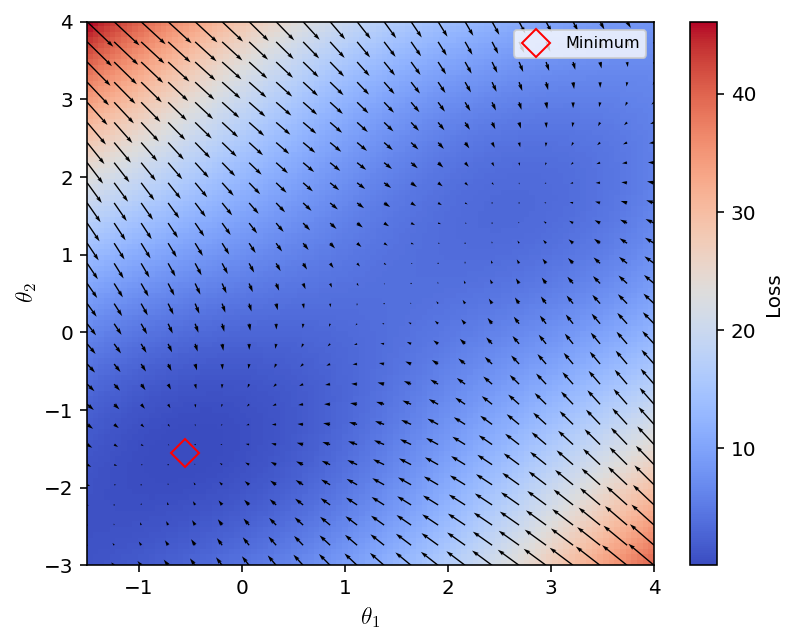

In [5]:
x, y = np.meshgrid(np.linspace(-1.5, 4, 100), np.linspace(-3, 4, 100))
z = mccormick(x, y)

fig = plt.figure(figsize=(6.35, 5))
ax = fig.add_subplot(1, 1, 1)
# Heatmap
im = ax.imshow(z, cmap="coolwarm", interpolation="nearest", origin="lower", aspect="auto", extent=[-1.5, 4, -3, 4])
# Quiver plot
a, b = np.meshgrid(np.linspace(-1.5, 4, 22), np.linspace(-3, 4, 28))
c, d = grad_mccormick(a, b)
q = ax.quiver(a, b, -c, -d, color="k")
# Annotations
ax.plot(-0.54719, -1.54719,  color="none", marker="D", mec="r", mfc="none", markersize=10, label="Minimum")
cb = fig.colorbar(im, ax=ax)
cb.set_label("Loss")
ax.set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
ax.set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
ax.legend(prop={"size": 8}, loc="upper right")
plt.savefig("assets/mccormick_contour.png", dpi=200, bbox_inches="tight")
plt.show()

A heatmap of the McCormick function, which is used as an artifical loss landscape. The quivers indicate the direction of the negative gradient.

#### Batch Gradient Descent

Batch gradient descent, sometimes denoted as vanilla or full-batch gradient descent, uses the gradient of the loss function for all training examples $\nabla_{\theta}J(\theta; x,y)$, i.e. the true gradient, to update the parameters of the model. Each update consists in adding the product of the learning rate $\eta$ and the negative gradient $-\nabla_{\theta}J(\theta; x, y)$ to the parameters $\theta$.

$$\theta \leftarrow \theta - \eta \cdot \nabla_{\theta}J(\theta; x, y)$$

Computing the true gradient for each update is slow and considerably slows down training. For this reason, other optimiziation algorithms that compute the gradient using a fraction of the dataset are usually preferred over batch gradient descent.

In [6]:
def bgd(params: np.ndarray, lr: float, epochs: int):
    """Batch gradient descent"""
    for epoch in range(epochs):
        grad = grad_mccormick(*params)
        params = params - lr * grad
        yield params

start = np.array([-1., 2.75])
bgd_mccormick = list(bgd(start, lr=0.01, epochs=10000))

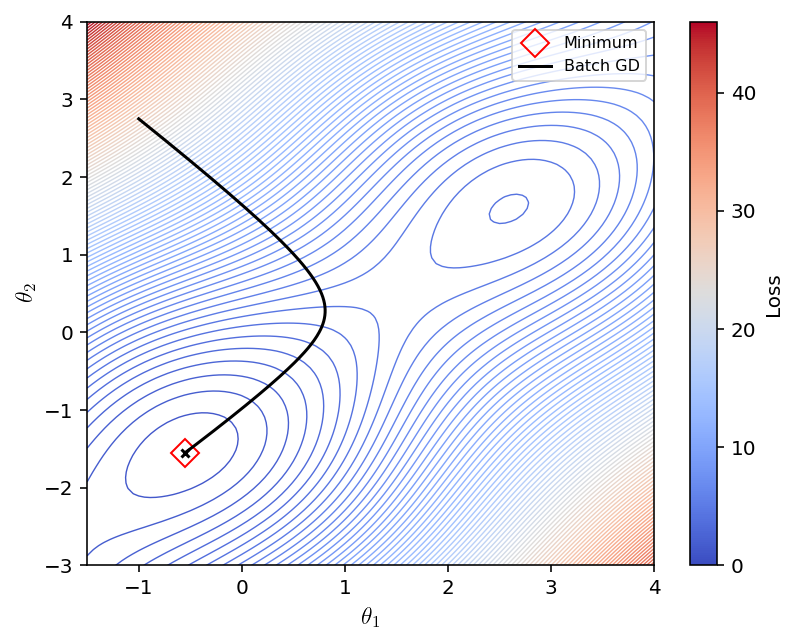

In [7]:
bgd_path = np.array([start, *bgd_mccormick])

fig = plt.figure(figsize=(6.35, 5))
ax = fig.add_subplot(1, 1, 1)
ax.contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
ax.plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Minimum")
ax.plot(bgd_path.T[0], bgd_path.T[1], color="k", linewidth=1.5, label="Batch GD")
ax.plot(*bgd_path[-1], "kx", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=ax)
cb.set_label("Loss")
ax.set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
ax.set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
ax.legend(prop={'size': 8})
plt.savefig("assets/mccormick_bgd.png", dpi=200, bbox_inches="tight")
plt.show()

#### Stochastic Gradient Descent

***Stochastic gradient descent*** (SGD) uses an approximation of the gradient $\nabla_{\theta}J(\theta; x, y)$ to optimize $J$. At each iteration, SGD randomly selects a training sample $x^{(i)}$ and its corresponding expected value $y^{(i)}$ to compute a stochastic approximation of the gradient and update the parameters $\theta$.

$$\theta \leftarrow \theta - \eta \cdot \nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$$

Samples are drawn either by randomly sampling the training data at each iteration, or by shuffling the dataset at each epoch and completing a whole pass through it. In its purest form, SGD uses a sample size of $1$, but can be generalized to larger sample sizes (see mini-batch gradient descent).

##### Stochasticity: Under the Hood

The gradient for all training examples $\nabla_{\theta}J(\theta; x, y)$ is the mean of the gradients of all training examples $\nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$.

$$\nabla_{\theta}J(\theta; x, y) = \frac{1}{n}\sum_{i=1}^n \nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$$

Each training example is unique and its gradient can differ significantly from that of other training examples. For a given parameter $\theta_j$, the partial derivative $\partial L / \partial \theta_j$ depends on the random sample of training data. The distribution of the partial derivative $\partial L / \partial \theta_j$ of all training examples can therefore be described by a probability density function $P$:

$$\dfrac{\partial L}{\partial \theta_j} \sim P$$

The shape, mean and standard deviation of $P$ depends on the model architecture, training dataset, and parameter in question. The mean and variance of the partial derivatives for one parameter can thus be drastically different than for another.

SGD randomly samples the probability distributions of gradients and is therefore a ***stochastic method***, i.e. it is well described by a random probability distribution.

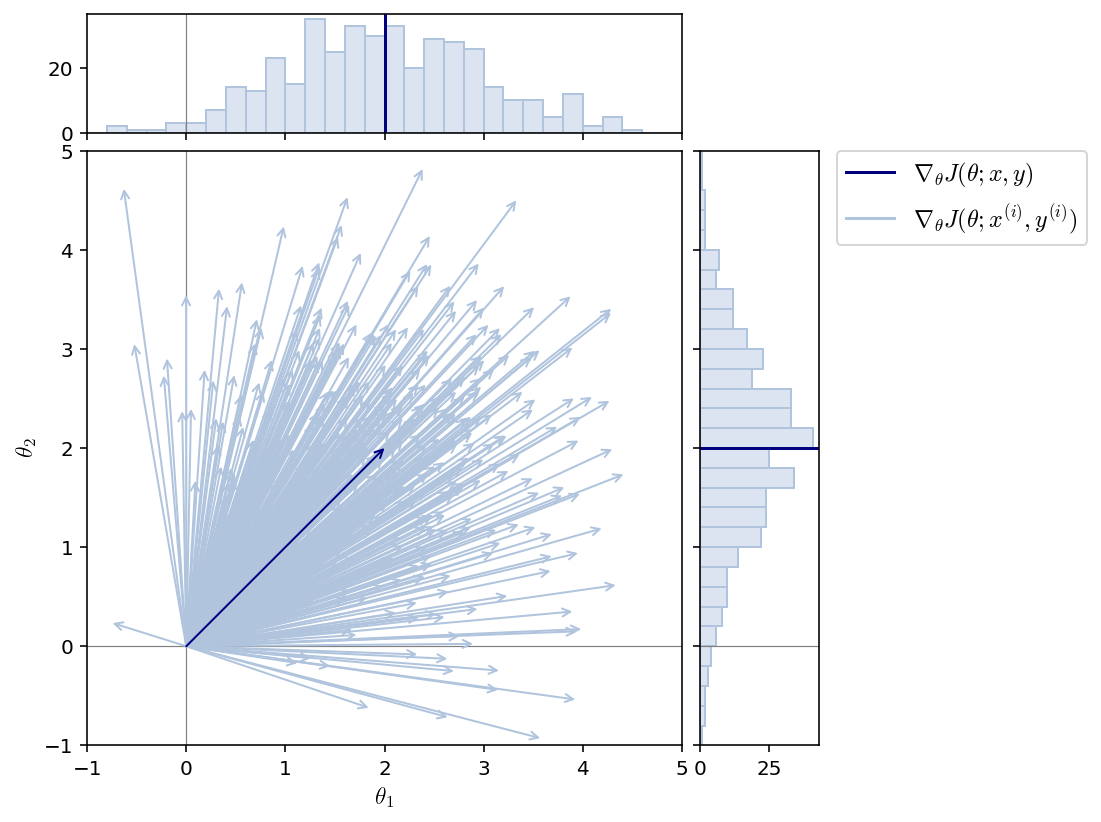

In [42]:
# Generate data
np.random.seed(0)
v = np.array([2, 2])
samples = 400
randx = np.random.normal(v[0], 1, size=(samples, 1))
randx = randx + v[0] - randx.sum() / samples
randy = np.random.normal(v[1], 1, size=(samples, 1))
randy = randy + v[1] - randy.sum() / samples
tf = np.concatenate((randx, randy), axis=1)

# Figure
fig = plt.figure(figsize=(6.35, 6.35))
gs = fig.add_gridspec(2, 2,  width_ratios=(7.5, 1.5), height_ratios=(1.5, 7.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# No labels on axes of histograms
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# Plot vectors
for x in tf:
    ax.annotate("", xy=tuple(x), xytext=(0, 0), arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color="lightsteelblue"))
ax.annotate("", xy=(2, 2), xytext=(0, 0), arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color="navy"))
ax.axis((-1, 5, -1, 5))
ax.axvline(0, linewidth=0.6, color="grey")
ax.axhline(0, linewidth=0.6, color="grey")

# Histograms
binwidth = 0.2
bins = np.arange(-1, 5+binwidth, binwidth)
ax_histx.hist(tf.T[0], density=False, bins=bins, color="#dbe4f0", edgecolor="lightsteelblue")
ax_histx.axvline(tf.T[0].mean(), color="navy", linewidth=1.5)
ax_histx.axvline(0, color="grey", linewidth=0.6)
ax_histy.hist(tf.T[1], density=False, bins=bins, color="#dbe4f0", edgecolor="lightsteelblue", orientation='horizontal')
ax_histy.axhline(tf.T[1].mean(), color="navy", linewidth=1.5)
ax_histy.axhline(0, color="grey", linewidth=0.6)
# Alt red color scheme
# Instance grad: #ffbfbf; full-batch grad: #ff0000; hist fill: #ffbfbf; hist edge: #ff8f8f

# Legend
ax.plot([], [], c="navy", label=r"$\nabla_{\theta}J(\theta; x, y)$")
ax.plot([], [], c="lightsteelblue", label= r"$\nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$")
ax.set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
ax.set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1.24, 1.02), prop={"size": 12})
plt.savefig("assets/stochasticity.png", dpi=200, bbox_inches="tight")
plt.show()

The figure above illustrates a distribution of gradients for two parameters $\theta_1$ and $\theta_2$. The mean of all gradients $\nabla_{\theta}J(\theta; x, y) = [2, 2]$. The gradients of the training examples $\nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$ are represented as following a normal distribution with standard deviation of $1$ on both parameters $\theta_1$ and $\theta_2$.

##### Simulated Stochasticity

The optimization of artificial landscapes such as the McCormick function is inherently different from that of neural networks. Artifical landscapes are optimized with respect to their real variables and their gradients cannot therefore be approximated stochasticly. However, to simulate the stochasticity of SGD, we can create an artificial stochastic process that generates approximations of a gradient.

We assume that the partial derivatives over the parameters $\theta_1$ and $\theta_2$ follow normal distributions with standard deviation of 16 and 4, respectively. These distributions are kept constant for all parameter values (this is not very realistic, but is good enough for our purpose). The key variables of our simulation are the dataset and batch size, which determine the expected accuracy of the approximated gradient. The dataset size is set to 40.

Based on the real gradient of the McCormick function, we draw 40 samples for each parameter according to the assumptions outlined above. These samples represent the gradients of all instances in the fictional dataset. The gradients are then normalized so that their mean corresponds to the real gradient. Finally, the approximation of the gradient is calculated by sampling a batch of gradients and finding its mean. 

In [28]:
DATASET_SIZE = 2000

def simulate_grad(params, batch):
    """Synthetic simulation of the gradient"""
    # Calculate the real gradient
    grad = grad_mccormick(*params)
    # Generate a distribution of partial derivatives of x with standard deviation of 16
    distx = np.random.normal(grad[0], 16, size=(DATASET_SIZE, 1))
    distx += grad[0] - distx.sum() / DATASET_SIZE
    # Generate a distribution of partial derivatives of y with standard deviation of 4
    disty = np.random.normal(grad[1], 4, size=(DATASET_SIZE, 1))
    disty += grad[1] - disty.sum() / DATASET_SIZE
    grads = np.concatenate((distx, disty), axis=1)
    # Sample a mini-batch and find its mean gradient
    batch_size = len(batch)
    idx = np.random.choice(grads.shape[0], batch_size, replace=False)
    grads = grads[idx, :]
    return grads.sum(axis=0) / batch_size

Based on this simulated gradient approximation, we can plot the path of SGD. The dataset is usually shuffled at each epoch, but this step is omitted here.

In [29]:
def sgd(data, params: np.ndarray, lr: float, epochs: int):
    """Stochastic Gradient Descent"""
    for epoch in range(epochs):
        for instance in data:
            grad = simulate_grad(params, [instance])
            params = params - lr * grad
            yield params

np.random.seed(10)
data = np.linspace(0, 1, DATASET_SIZE)
sgd_mccormick = list(sgd(data, start, lr=0.001, epochs=2))

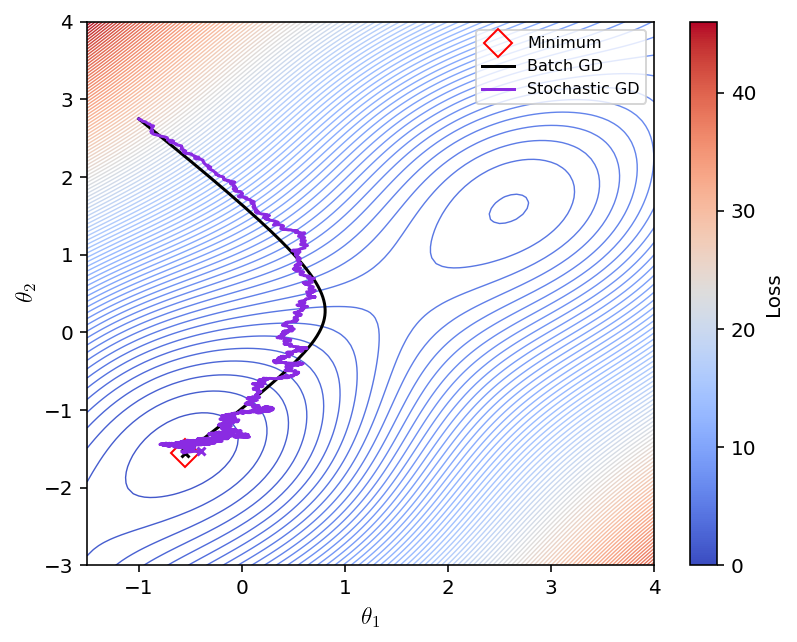

In [30]:
sgd_path = np.array([start, *sgd_mccormick])
# 2 epochs * 4000 steps per epoch = 8000 steps
epochs = 1
sgd_path = sgd_path[:2800]

# fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))
fig, axes = plt.subplot_mosaic(mosaic="A", figsize=(6.35, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Minimum")
# Plot the path of batch gradient descent
axes["A"].plot(bgd_path.T[0], bgd_path.T[1], color="k", linewidth=1.5, label="Batch GD")
axes["A"].plot(*bgd_path[-1], "kx", markersize=4, markeredgewidth=1.5)
# Plot the path of SGD
axes["A"].plot(sgd_path.T[0], sgd_path.T[1], color="blueviolet", linewidth=1.5, label="Stochastic GD")
axes["A"].plot(*sgd_path[-1], marker="x", color="blueviolet", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
cb.set_label("Loss")
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
axes["A"].legend(prop={'size': 8})

# Calculate the loss at each timestep
# bgd_losses = [mccormick(*params) for params in bgd_path]
# sgd_losses = [mccormick(*params) for params in sgd_path]
# axes["B"].plot(bgd_losses[:epochs], color="k", label="Batch GD")
# axes["B"].plot(np.linspace(0, epochs, epochs*len(data)), sgd_losses, color="blueviolet", label="Stochastic GD")
# axes["B"].legend(prop={'size': 8})
# axes["B"].set_ylim([0,30])
# axes["B"].set_xlim(xmin=0, xmax=epochs)
# axes["B"].set_xlabel("Epochs")
# axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_sgd.png", dpi=200, bbox_inches='tight')
plt.show()

The primary advantage of SGD over batch gradient descent is that it is less computationally expensive and therefore converges faster. However, by computing only an approximation of the true gradient, SGD makes a tradeoff between speed and precision of convergence. While batch gradient descent has small gradients near minima, SGD can struggle to settle near minima due to its high stochasticity.

#### Mini-batch Gradient Descent

***Mini-batch gradient descent*** is a generalization of batch and stochastic gradient to any sample size. Every update is performed with a batch of $n$ training examples:

$$\theta \leftarrow \theta - \eta \cdot \nabla_{\theta}J(\theta; x^{(i:i+n)}, y^{(i:i+n)})$$

The advantage of mini-batch gradient descent is that using a batch size larger than $1$ improves the accuracy of the approximated gradient. Moreover, thanks to highly-optimized linear algebra libraries, computing the gradient of mini-batches that fit into memory is often only marginally slower than computing it for a single training example. However, the accuracy of the approximated gradient, as measured by the standard error of the mean, increass less than linearly. The standard error of the mean $\sigma_{\bar{x}}$ is given by:

$$\sigma_{\bar{x}} = \frac{\sigma}{\sqrt{n}}$$

where $\sigma$ is the true standard deviation of the distribution and $n$ is the number of samples drawn. The factor $1 / \sqrt{n}$ indicates that reducing the standard error of the mean requires exponentially more samples. Beyond a certain size, large batches have therefore diminishing returns. Memory and IO bandwidth limit vectorization and it becomes preferrable to update the parameters more frequently rather than caclulate more accurate gradients.

In [31]:
def minibatchgd(data, params: np.ndarray, lr: float, epochs, batch_size: int):
    """Mini-batch Gradient Descent"""
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            grad = simulate_grad(params, batch)
            params = params - lr * grad
            yield params

np.random.seed(5)
minibatch_mccormick = list(minibatchgd(data, start, lr=0.001, epochs=10, batch_size=4))

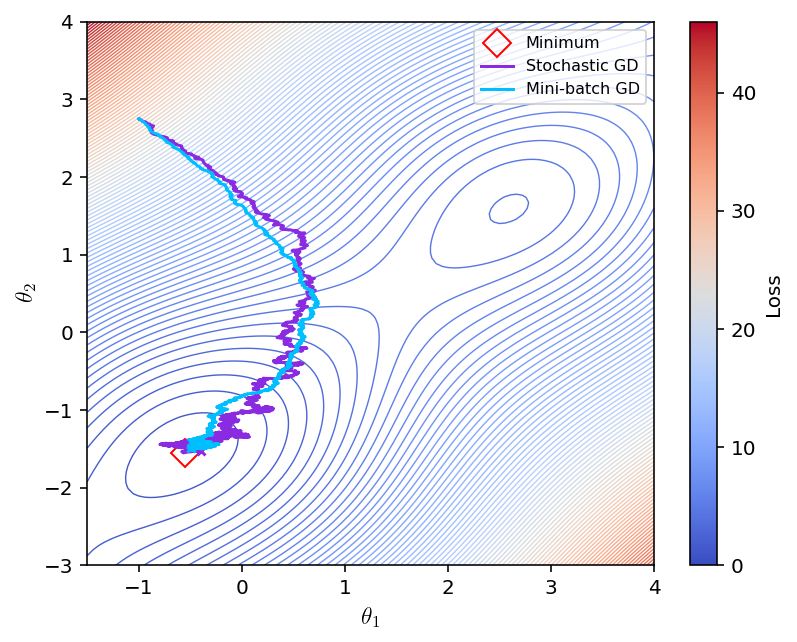

In [127]:
minibatch_path = np.array([start, *minibatch_mccormick])
# 1 epochs * (4000 / 4) = 1000 steps
epochs = 1
minibatch_path = minibatch_path[:2800]
sgd_path = np.array([start, *sgd_mccormick])
# 1 epochs * 40 steps per epoch = 8000 steps
sgd_path = sgd_path[:2800]

# fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))
fig, axes = plt.subplot_mosaic(mosaic="A", figsize=(6.35, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Minimum")
# Plot the path of SGD
axes["A"].plot(sgd_path.T[0], sgd_path.T[1], color="blueviolet", linewidth=1.5, label="Stochastic GD")
axes["A"].plot(*sgd_path[-1], marker="x", color="blueviolet", markersize=4, markeredgewidth=1.5)
# Plot the path of mini-batch gradient descent
axes["A"].plot(minibatch_path.T[0], minibatch_path.T[1], color="deepskyblue", linewidth=1.5, label="Mini-batch GD")
axes["A"].plot(*minibatch_path[-1], color="deepskyblue", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
cb.set_label("Loss")
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
axes["A"].legend(prop={'size': 8})

# Calculate the loss at each timestep
# minibatch_losses = [mccormick(*params) for params in minibatch_path]
# sgd_losses = [mccormick(*params) for params in sgd_path]
# axes["B"].plot(np.linspace(0, epochs, epochs*len(data)), sgd_losses, color="blueviolet", label="Stochastic GD")
# axes["B"].plot(np.linspace(0, epochs, 1000), minibatch_losses, color="deepskyblue", label="Mini-batch GD")
# axes["B"].legend(prop={'size': 8})
# axes["B"].set_yscale("symlog")
# axes["B"].set_ylim([0,30])
# axes["B"].set_xlim(xmin=0, xmax=epochs)
# axes["B"].set_xlabel("Epochs")
# axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_minibatch.png", dpi=200, bbox_inches='tight')
plt.show()

Note that the number of epochs is not indicative of the speed in wall-clock time of an optimizer. The number of epochs, together with the batch size, merely indicates the number of updates the optimizers performs until it converges. To assess the speed of an optimizer we would need to analyse the time complexity of the gradient calculation and parameter update, or run an experiment.

In the graph above, stochastic gradient descent converges in approximatly 50 epochs while mini-batch gradient descent takes around 160 epochs. Since the fictional training dataset has 40 examples, we can estimate that stochastic GD performed 2000 updates (40\*50) until it converged while mini-batch performed a total of 1600 updates (40/4\*160).

#### Momentum

***Momentum*** calculates an exponentially decaying moving average of past gradients to update the parameters. A variable $v$ represents this decaying moving average as the velocity of the gradients. For each update $t$, the momentum algorithm adds a fraction $\gamma \in [0,1)$ of the previous velocity $v_{t-1}$ to the current update vector:

$$v_t = \gamma v_{t-1} + \eta\nabla_{\theta}J(\theta)$$

$$\theta \leftarrow \theta - v_t$$

The momentum term $\gamma$ determines how quickly the velocity decays. A typical value for $\gamma$ is $0.9$.

In [73]:
def momentum(params: np.ndarray, lr: float, gamma:float, epochs: int, batch_size):
    """Momentum optimizer"""
    velocity = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            grad = simulate_grad(params, batch)
            update = gamma * velocity + lr * grad
            params = params - update
            velocity = update
            yield params

np.random.seed(5)
momentum_mccormick = list(momentum(start, lr=0.00005, gamma=0.98, epochs=10, batch_size=4))

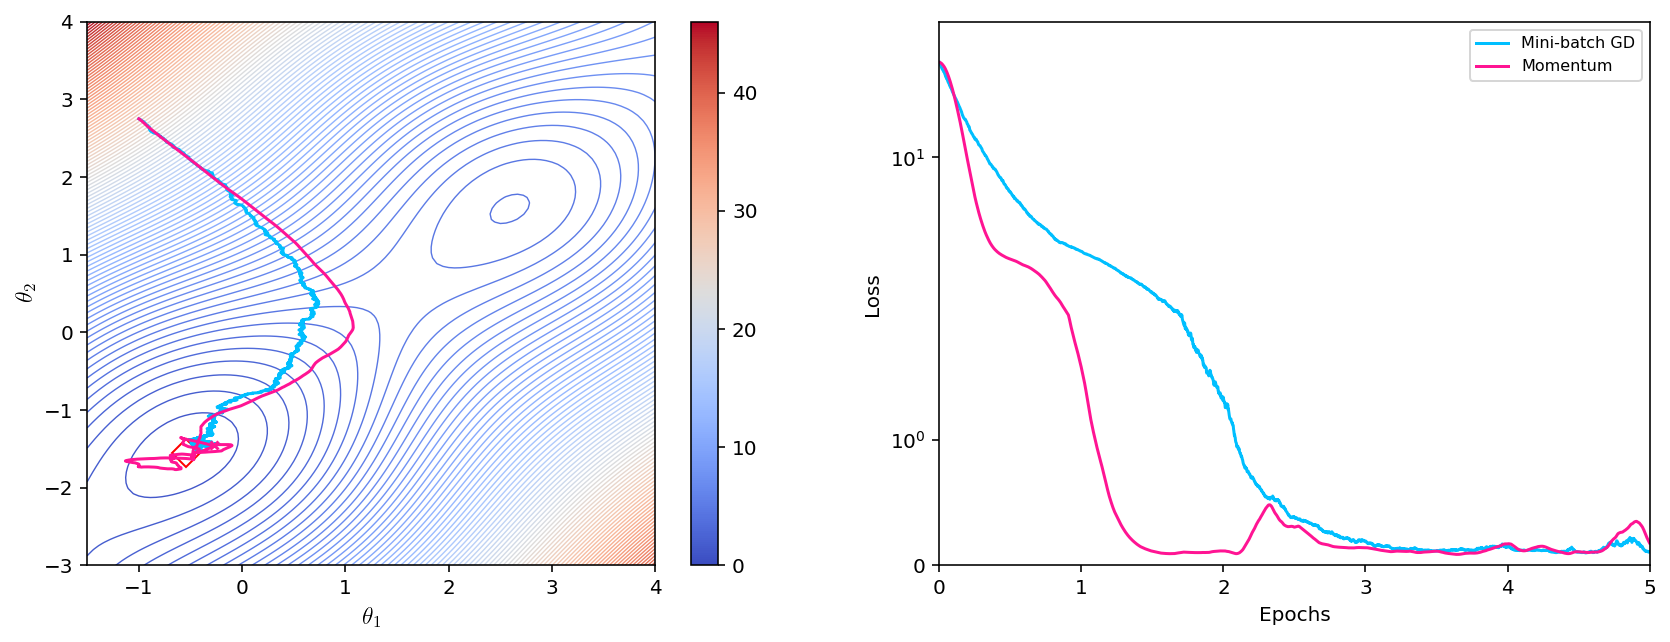

In [74]:
momentum_path = np.array([start, *momentum_mccormick])
epochs = 5
steps = int(DATASET_SIZE / 4 * epochs)
momentum_path = momentum_path[:steps]
minibatch_path = np.array([start, *minibatch_mccormick])
minibatch_path = minibatch_path[:steps]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of mini-batch gradient descent
axes["A"].plot(minibatch_path.T[0], minibatch_path.T[1], color="deepskyblue", linewidth=1.5, label="Mini-batch GD")
axes["A"].plot(*minibatch_path[-1], color="deepskyblue", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Momentum
axes["A"].plot(momentum_path.T[0], momentum_path.T[1], color="deeppink", linewidth=1.5, label="Momentum")
axes["A"].plot(*momentum_path[-1], color="deeppink", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
momentum_losses = [mccormick(*params) for params in momentum_path]
minibatch_losses = [mccormick(*params) for params in minibatch_path]
axes["B"].plot(np.linspace(0, epochs, steps), minibatch_losses, color="deepskyblue", label="Mini-batch GD")
axes["B"].plot(np.linspace(0, epochs, steps), momentum_losses, color="deeppink", label="Momentum")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_momentum.png", dpi=200, bbox_inches='tight')
plt.show()

The graph below illustrates some of the characterisitcs of momentum and mini-batch gradient descent on the artificial landscape generated by the Rosenbrock function. Momentum is able to navigate through the ravine and settle near the global minimum while mini-batch gradient descent oscillates at the start and struggles to advance through the bottom of the ravine where gradients are small.

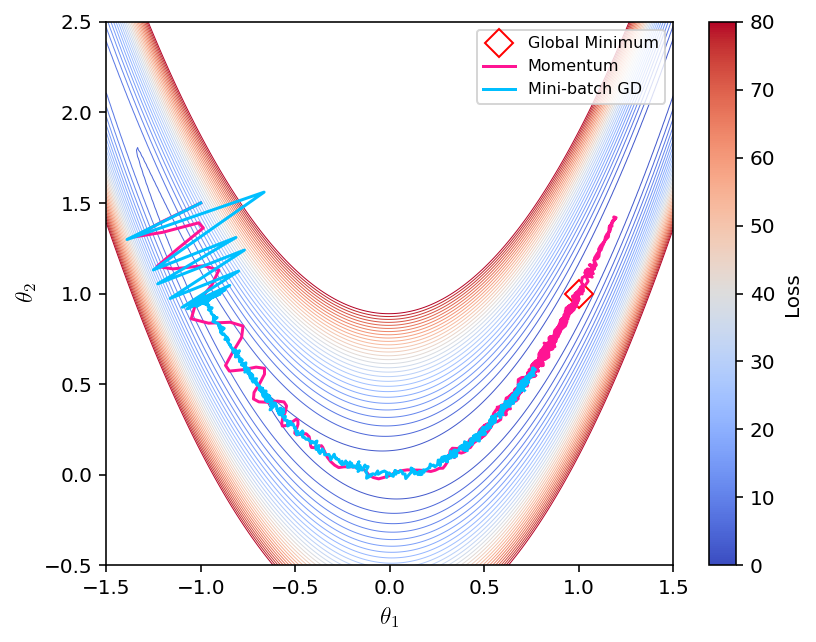

In [56]:
def rosenbrock(x, y):
    """Rosenbrock function"""
    return (1 - x)**2 + 100*(y - x**2)**2

grad_rosenbrock = jit(grad(rosenbrock, argnums=(0, 1)))
grad_rosenbrock_np = lambda x, y: np.array(grad_rosenbrock(x, y), ndmin=1)

def simulate_grad(x, y, dataset_size, batch_size):
    """Synthetic simulation of the gradient"""
    # Calculate the real gradient
    grad = grad_rosenbrock_np(x, y)
    # Generate a sample of partial derivatives of x with standard deviation of 2
    distx = np.random.normal(grad[0], 4, size=(dataset_size, 1))
    distx += grad[0] - distx.sum() / dataset_size
    # Generate a sample of partial derivatives of y with standard deviation of 2
    disty = np.random.normal(grad[1], 8, size=(dataset_size, 1))
    disty += grad[1] - disty.sum() / dataset_size
    grads = np.concatenate((distx, disty), axis=1)
    # Sample a mini-batch and find its mean gradient
    idx = np.random.choice(grads.shape[0], batch_size, replace=False)
    grads = grads[idx, :]
    return grads.sum(axis=0) / batch_size

def minibatchgd(data, params: np.ndarray, lr: float, epochs, batch_size: int):
    """Mini-batch Gradient Descent"""
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), len(batch))
            params = params - lr * grad
            yield params

def momentum(data, params: np.ndarray, lr: float, gamma:float, epochs: int, batch_size):
    """Momentum optimizer"""
    velocity = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), len(batch))
            update = gamma * velocity + lr * grad
            params = params - update
            velocity = update
            yield params

np.random.seed(1)
start = np.array([-1, 1.5])

minibatch_rosenbrock = list(minibatchgd(data, start, lr=0.002, epochs=100, batch_size=4))
minibatch_rosenbrock_path = np.array([start, *minibatch_rosenbrock])

momentum_rosenbrock = list(momentum(data, start, lr=0.001, gamma=0.9, epochs=100, batch_size=4))
momentum_rosenbrock_path = np.array([start, *momentum_rosenbrock])

x, y = np.meshgrid(np.linspace(-1.5, 1.5, 200), np.linspace(-.5, 2.5, 200))
z = rosenbrock(x, y)

fig = plt.figure(figsize=(6.35, 5))
ax = fig.add_subplot(1, 1, 1)
ax.contour(x, y, z, levels=np.linspace(0, 80, 30), cmap="coolwarm", linewidths=0.5)
ax.plot(1, 1,  color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of Momentum
ax.plot(momentum_rosenbrock_path.T[0], momentum_rosenbrock_path.T[1], color="deeppink", linewidth=1.5, label="Momentum")
ax.plot(*momentum_rosenbrock_path[-1], color="deeppink", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Mini-batch GD
ax.plot(minibatch_rosenbrock_path.T[0], minibatch_rosenbrock_path.T[1], color="deepskyblue", linewidth=1.5, label="Mini-batch GD")
ax.plot(*minibatch_rosenbrock_path[-1], color="deepskyblue", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 80.)
cb = fig.colorbar(m, ax=ax)
cb.set_label("Loss")
ax.set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
ax.set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
ax.legend(prop={'size': 8})
plt.savefig("assets/rosenbrock.png", dpi=200, bbox_inches='tight')
plt.show()

#### Adagrad

***Adagrad*** ([Duchi et al.](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf), 2011), short for Adaptive Gradient Algorithm, adapts the learning rate individually to all parameters during training. For each update, Adagrad scales the learning rate for each parameter by dividing it by the square root of the outer product matrix $G_t$, given by:

$$G_t = \sum^t_{\tau=1} g_{\tau}g_{\tau}^\top$$

Since calculating the square root of $G_t$ is computationally impractical, we update the parameters using its diagonal, $diag(G_t)$, which is effectively the sum of the historical squared gradients of all parameters (ibid, p. 2122).

In [69]:
g = np.array([[-1., 2.75]])
(np.diagonal(g * g.T) == g**2).all()

True

The update vector is then the element-wise multiplication (Hadamard product) of the learning rates and the gradient:

$$\theta \leftarrow \theta - \frac{\eta}{\epsilon + \sqrt{diag(G_t)}} \odot g_t$$

where $\epsilon$ is a smoothing term used to avoid division by zero.

In [117]:
def adagrad(data, params: np.ndarray, lr: float, epochs, batch_size: int, eps=1e-8):
    """Adagrad optimizer"""
    Gt = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            grad = simulate_grad(params, batch)   
            Gt += grad**2
            update = lr / np.sqrt(Gt + eps) * grad
            params = params - update
            yield params

np.random.seed(5)
adagrad_mccormick = list(adagrad(data, start, lr=0.15, epochs=10, batch_size=4))

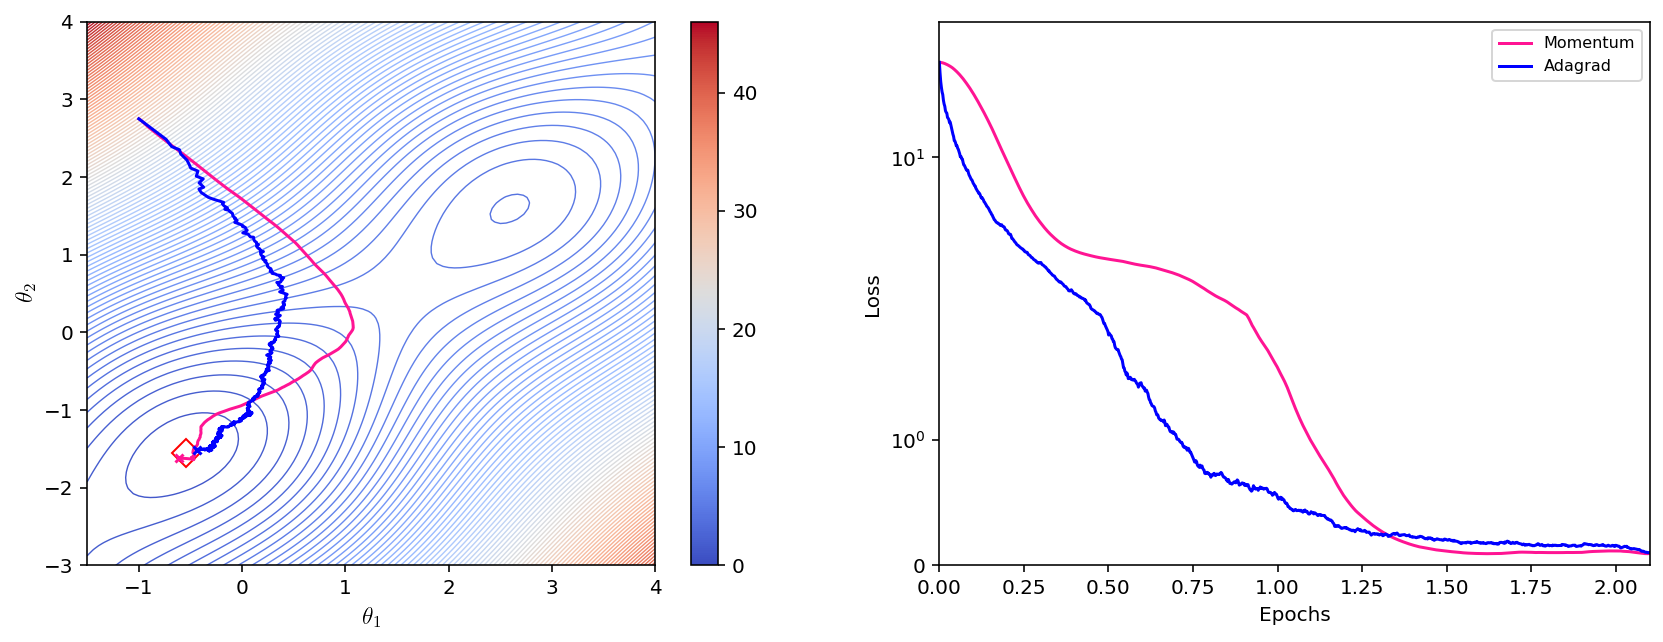

In [118]:
epochs = 2.1
steps = int(DATASET_SIZE / 4 * epochs)
momentum_path = np.array([start, *momentum_mccormick])
momentum_path = momentum_path[:steps]
adagrad_path = np.array([start, *adagrad_mccormick])
adagrad_path = adagrad_path[:steps]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of Momentum
axes["A"].plot(momentum_path.T[0], momentum_path.T[1], color="deeppink", linewidth=1.5, label="Momentum")
axes["A"].plot(*momentum_path[-1], color="deeppink", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Adagrad
axes["A"].plot(adagrad_path.T[0], adagrad_path.T[1], color="b", linewidth=1.5, label="Adagrad")
axes["A"].plot(*adagrad_path[-1], color="b", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
adagrad_losses = [mccormick(*params) for params in adagrad_path]
momentum_losses = [mccormick(*params) for params in momentum_path]
axes["B"].plot(np.linspace(0, epochs, steps), momentum_losses, color="deeppink", label="Momentum")
axes["B"].plot(np.linspace(0, epochs, steps), adagrad_losses, color="b", label="Adagrad")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_adagrad.png", dpi=200, bbox_inches='tight')
plt.show()

Like other optimizers with adaptive learning rates, Adagrad is able to finely adjust parameters to which the model is highly sensitive. However, the accumulation of past squared gradients monotonously decreases the learning rate, which can become infinitesimally small. Such premature and excessive decrease of the learning rate can prevent or slow down convergence.

#### RMSprop

***RMSprop*** ([Hinton](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), 2012) seeks to address the shortfalls of Adagrad by using an exponentially decaying average of past squared gradients to adapt the learning rate. The average $E[g^2]_t$ for each update $t$ is given by:

$$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma)g^2_t$$

where $g_t$ is the current gradient and $\gamma \in [0, 1)$ is the decay factor. The update rule is similar to that of Adagrad:

$$\theta \leftarrow \theta - \frac{\eta}{\epsilon + \sqrt{E[g^2]_t}} \odot g_t$$

Hinton (2012) recommends setting $\gamma$ to $0.9$ and the learning rate to $0.001$ (slide 29).


In [108]:
def rmsprop(data, params: np.ndarray, lr: float, epochs: int, gamma:float, batch_size: int, eps=1e-8):
    """RMSprop optimizer"""
    average = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            grad = simulate_grad(params, batch)
            average = gamma * average + (1 - gamma) * grad**2
            update = lr / np.sqrt(average + eps) * grad
            params = params - update
            yield params

np.random.seed(5)
rmsprop_mccormick = list(rmsprop(data, start, lr=0.01, epochs=10, gamma=0.9, batch_size=4))

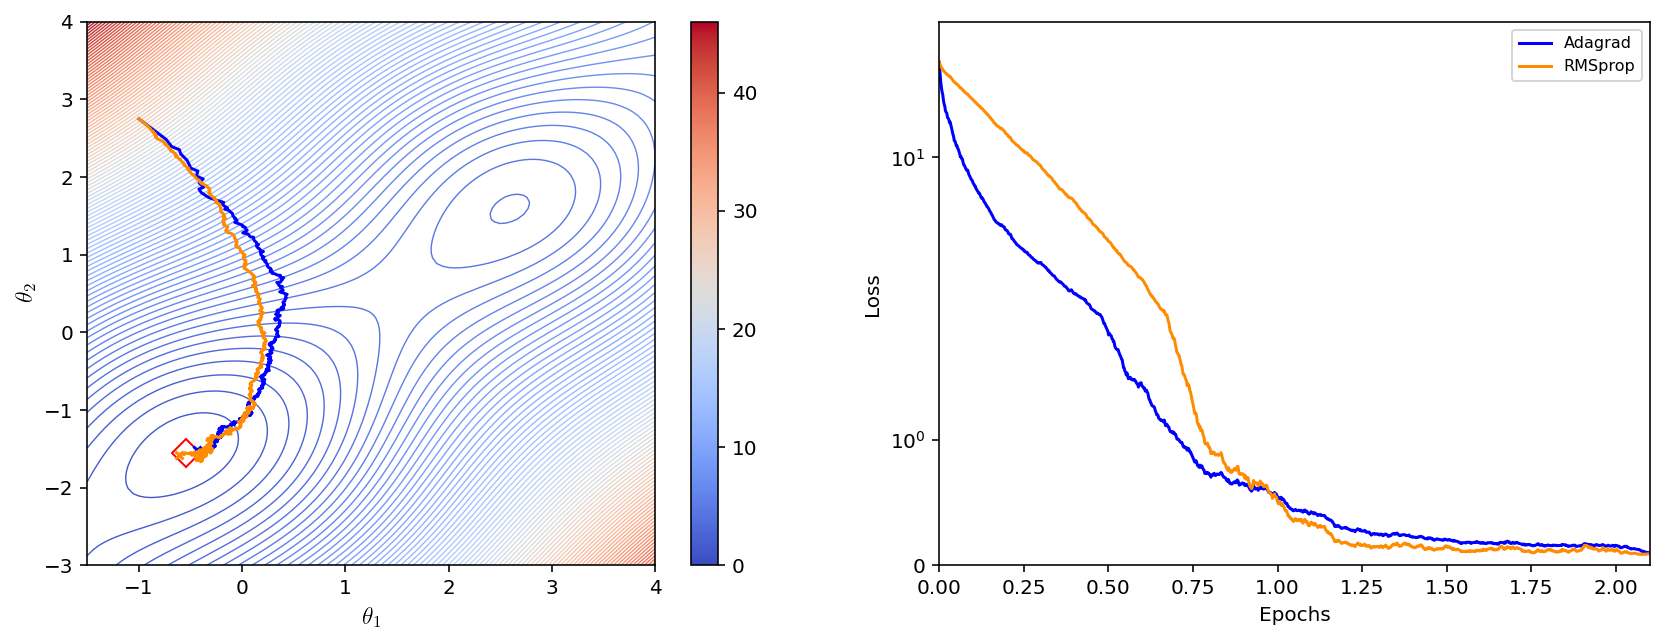

In [119]:
epochs = 2.1
steps = int(DATASET_SIZE / 4 * epochs)
adagrad_path = np.array([start, *adagrad_mccormick])
adagrad_path = adagrad_path[:steps]
rmsprop_path = np.array([start, *rmsprop_mccormick])
rmsprop_path = rmsprop_path[:steps]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of Adagrad
axes["A"].plot(adagrad_path.T[0], adagrad_path.T[1], color="b", linewidth=1.5, label="Adagrad")
axes["A"].plot(*adagrad_path[-1], color="b", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of RMSprop
axes["A"].plot(rmsprop_path.T[0], rmsprop_path.T[1], color="darkorange", linewidth=1.5, label="RMSprop")
axes["A"].plot(*rmsprop_path[-1], color="darkorange", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
rmsprop_losses = [mccormick(*params) for params in rmsprop_path]
axes["B"].plot(np.linspace(0, epochs, steps), adagrad_losses, color="b", label="Adagrad")
axes["B"].plot(np.linspace(0, epochs, steps), rmsprop_losses, color="darkorange", label="RMSprop")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_rmsprop.png", dpi=200, bbox_inches='tight')
plt.show()

#### Adam

***Adam*** ([Kingma and Ba](https://arxiv.org/pdf/1412.6980.pdf), 2015), which stands for Adaptive Moment Estimation, is another adaptive learning rate optimizer. Adam uses estimates of the mean (1st moment) and uncentered variance (2nd moment) of the gradient to update the parameters. The estimate of the mean is given by the exponential moving averages of the gradient $m_t$:

$$m_t = \beta_1 m_{t - 1} + (1 - \beta_1)g_t$$

The estimate of the variance is given, like for RMSprop, by the exponential moving average of the squared gradient $v_t$:

$$v_t = \beta_2 v_{t - 1} + (1 - \beta_2)g_t^2$$

The moving averages are initialized as vectors of 0's and, particularly during the first steps, are therefore biased towards zero. Adam therefore calculates the bias-corrected estimates $\hat{m_t}$ and $\hat{v_t}$:

$$\hat{m_t} = \frac{m_t}{1 - \beta_1^t}$$

$$\hat{v_t} = \frac{v_t}{1 - \beta_2^t}$$

$\beta_1^t$ and $\beta_2^t$ denote $\beta_1$ and $\beta_2$ to the power of $t$. Updating the parameters consists in adapting the learning rate to the parameters based on $v_t$ and multiplying these individual learning rates with $\hat{m_t}$:

$$\theta \leftarrow \theta - \frac{\eta}{\epsilon + \sqrt{\hat{v_t}}} \odot \hat{m_t}$$

Kingma and Ba (2015) suggest using $\beta_1 = 0.9$ and $\beta_2 = 0.999$ as defaults.

In [93]:
def adam(data, params: np.ndarray, lr: float, epochs, b1, b2, batch_size: int, eps=1e-8):
    """Adam optimizer"""
    t = 0
    m = np.zeros(params.shape)
    v = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            t += 1
            batch = data[i:i+batch_size]
            grad = simulate_grad(params, batch)
            m = b1 * m + (1 - b1) * grad
            v = b2 * v + (1 - b2) * grad**2
            m_hat = m / (1 - b1**t)
            v_hat = v / (1 - b2**t)
            params = params - (lr / (np.sqrt(v_hat) + eps) * m_hat) 
            yield params

np.random.seed(5)
start = np.array([-1., 2.75])
adam_mccormick = list(adam(data, start, lr=0.01, epochs=10, b1=0.9, b2=0.999, batch_size=4))

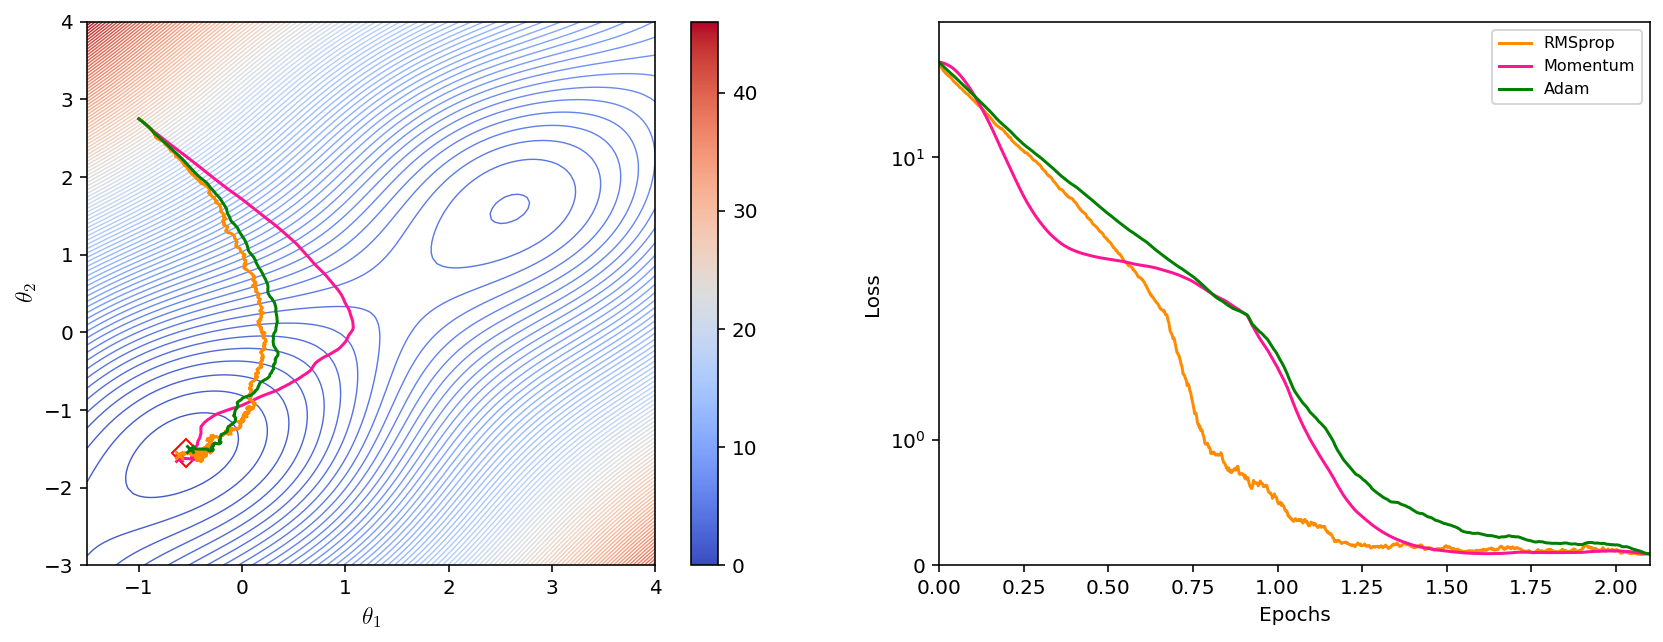

In [120]:
epochs = 2.1
steps = int(DATASET_SIZE / 4 * epochs)
momentum_path = np.array([start, *momentum_mccormick])
momentum_path = momentum_path[:steps]
rmsprop_path = np.array([start, *rmsprop_mccormick])
rmsprop_path = rmsprop_path[:steps]
adam_path = np.array([start, *adam_mccormick])
adam_path = adam_path[:steps]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of Momentum
axes["A"].plot(momentum_path.T[0], momentum_path.T[1], color="deeppink", linewidth=1.5, label="Momentum")
axes["A"].plot(*momentum_path[-1], color="deeppink", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Adagrad
axes["A"].plot(rmsprop_path.T[0], rmsprop_path.T[1], color="darkorange", linewidth=1.5, label="RMSprop")
axes["A"].plot(*rmsprop_path[-1], color="darkorange", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Adam
axes["A"].plot(adam_path.T[0], adam_path.T[1], color="g", linewidth=1.5, label="Adam")
axes["A"].plot(*adam_path[-1], color="g", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
momentum_losses = [mccormick(*params) for params in momentum_path]
rmsprop_losses = [mccormick(*params) for params in rmsprop_path]
adam_losses = [mccormick(*params) for params in adam_path]
axes["B"].plot(np.linspace(0, epochs, steps), rmsprop_losses, color="darkorange", label="RMSprop")
axes["B"].plot(np.linspace(0, epochs, steps), momentum_losses, color="deeppink", label="Momentum")
axes["B"].plot(np.linspace(0, epochs, steps), adam_losses, color="g", label="Adam")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_adam.png", dpi=200, bbox_inches='tight')
plt.show()

In [106]:
# Figure
fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))
axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Minimum")
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Animated gradient descent paths
# Mini-batch GD
minibatch_line, = axes["A"].plot([], [], color="deepskyblue", linewidth=1.5, label="Mini-batch GD")
minibatch_marker, = axes["A"].plot([], [], color="deepskyblue", marker="o", markersize=3, markeredgewidth=1.5)
# Momentum
momentum_line, = axes["A"].plot([], [], color="deeppink", linewidth=1.5, label="Momentum")
momentum_marker, =  axes["A"].plot([], [], color="deeppink", marker="o", markersize=3, markeredgewidth=1.5)
# Adagrad
adagrad_line, = axes["A"].plot([], [], color="b", linewidth=1.5, label="Adagrad")
adagrad_marker, =  axes["A"].plot([], [], color="b", marker="o", markersize=3, markeredgewidth=1.5)
# RMSprop
rmsprop_line, = axes["A"].plot([], [], color="darkorange", linewidth=1.5, label="RMSprop")
rmsprop_marker, =  axes["A"].plot([], [], color="darkorange", marker="o", markersize=3, markeredgewidth=1.5)
# Adam
adam_line, = axes["A"].plot([], [], color="g", linewidth=1.5, label="Adam")
adam_marker, =  axes["A"].plot([], [], color="g", marker="o", markersize=3, markeredgewidth=1.5)

axes["A"].legend(prop={'size': 8})


# Animated loss graphs
# Mini-batch GD
minibatch_loss, = axes["B"].plot([], [], color="deepskyblue", label="Mini-batch GD")
# Momentum
momentum_loss, = axes["B"].plot([], [], color="deeppink", label="Momentum")
# Adagrad
adagrad_loss, = axes["B"].plot([], [], color="b", label="Adagrad")
# RMSprop
rmsprop_loss, = axes["B"].plot([], [], color="darkorange", label="RMSprop")
# Adam
adam_loss, = axes["B"].plot([], [], color="g", label="Adam")

axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")

# Initialization function
def init():
    # Mini-batch GD
    minibatch_line.set_data([], [])
    minibatch_loss.set_data([], [])
    minibatch_marker.set_data([], [])
    # Momentum
    momentum_line.set_data([], [])
    momentum_loss.set_data([], [])
    momentum_marker.set_data([], [])
    # Adagrad
    adagrad_line.set_data([], [])
    adagrad_loss.set_data([], [])
    adagrad_marker.set_data([], [])
    # RMSprop
    rmsprop_line.set_data([], [])
    rmsprop_loss.set_data([], [])
    rmsprop_marker.set_data([], [])
    # Adam
    adam_line.set_data([], [])
    adam_loss.set_data([], [])
    adam_marker.set_data([], [])

    return minibatch_line, minibatch_loss, minibatch_marker, \
        momentum_line, momentum_loss, momentum_marker, \
        adagrad_line, adagrad_loss, adagrad_marker, \
        rmsprop_line, rmsprop_loss, rmsprop_marker, \
        adam_line, adam_loss, adam_marker

# Animation function (called sequentially)
def animate(i):
    steps = np.linspace(0, i*0.002, i)
    # Mini-batch GD
    minibatch_line.set_data(*minibatch_path.T[:, :i])
    minibatch_loss.set_data(steps, minibatch_losses[:i])
    minibatch_marker.set_data(*minibatch_path[i])
    # Momentum
    momentum_line.set_data(*momentum_path.T[:, :i])
    momentum_loss.set_data(steps, momentum_losses[:i])
    momentum_marker.set_data(*momentum_path[i])
    # Adagrad
    adagrad_line.set_data(*adagrad_path.T[:, :i])
    adagrad_loss.set_data(steps, adagrad_losses[:i])
    adagrad_marker.set_data(*adagrad_path[i])
    # RMSprop
    rmsprop_line.set_data(*rmsprop_path.T[:, :i])
    rmsprop_loss.set_data(steps, rmsprop_losses[:i])
    rmsprop_marker.set_data(*rmsprop_path[i])
    # Adam
    adam_line.set_data(*adam_path.T[:, :i])
    adam_loss.set_data(steps, adam_losses[:i])
    adam_marker.set_data(*adam_path[i])

    return minibatch_line, minibatch_loss, minibatch_marker, \
        momentum_line, momentum_loss, momentum_marker, \
        adagrad_line, adagrad_loss, adagrad_marker, \
        rmsprop_line, rmsprop_loss, rmsprop_marker, \
        adam_line, adam_loss, adam_marker

anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=1050, interval=14,
    repeat_delay=2000, blit=True
)
plt.close()

In [121]:
anim.save('gradientdescent.mp4', dpi=200)

### Hazards

#### Dying ReLU neurons

ReLU neurons output zero if their weighted sum is negative (i.e. when they have negative weights, negative inputs or a large negative bias). While this property can be beneficial in the form of sparsity, it can become problematic if a neuron consistently outputs zero for any input values. Since $RELU'(z) = 0$ when $z <= 0$, the parameters are not updated and the neuron dies.

Mini-batch stochastic gradient descent generates new batches at each iteration and, as long as not all inputs lead to a negative weighted sum, can prevent a neuron from becoming completely inactive. However, a high learning-rate can also lead to consistently negative weighted sums by updating the weights to high negative values. A lower learning rate or the use of an alternative activation function such as *Leaky ReLU* can mitigate this issue.

#### Vanishing gradients

Gradients can diminish drastically when they are backpropagated through a deep neural network during training. By the time the error reaches the first layers, the gradient can become so small that it is  "diﬃcult to know [in] which direction the parameters should move to improve the cost function" (Goodfellow et al, 2016, p. 290). Vanishing gradients can slow down and even prevent convergence. This issue is particularly salient in Recurrent Neural Networks (RNNs), which have a high number of steps, or in networks using the sigmoid/tanh activation functions. Alleviations include paying special attention to the weight initialization scheme, or using an alternative activation function.

#### Initialization

> [...] training deep models is a suﬃciently diﬃcult task that most algorithms are strongly aﬀected by the choice of initialization. The initial point can determine whether the algorithm converges at all, with some initial points being so unstable that the algorithm encounters numerical diﬃculties and fails altogether.
>
> (Goodfellow et al., 2016, p. 301)

A key function of initialization is to break the symmetry between different neurons. If all parameters in a given dense layer were initialized with the same constant, they would all compute the same ouputs and receive the same updates. 
Random initialization breaks this symmetry and creates asymmetries that can be tweaked through backpropagation and SGD to train the neural network.

Typicaly, only the weights are initialized randomly while the biases are set to a heuristically chosen constant.

A simple method of weight intialization is to sample values from a Gaussian probability distribution with mean `0` and a standard deviation of `1`.

Minimum: -4.4978   Maximum: 4.1724
Mean:    0.0018   SD: 1.0009


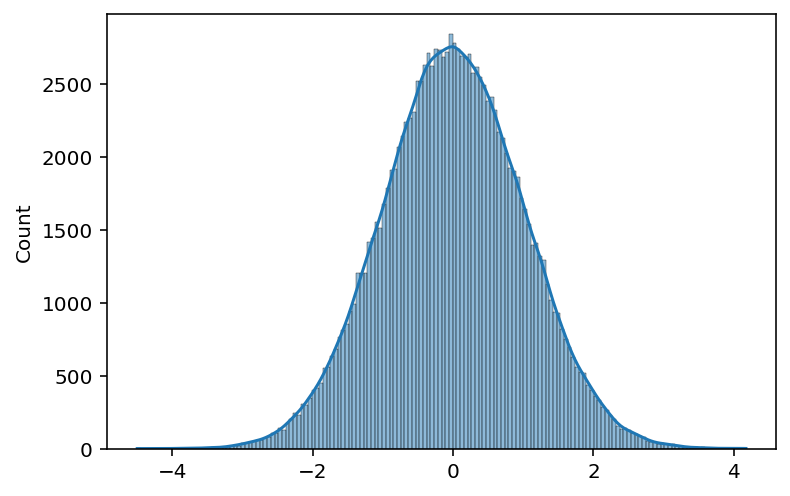

In [52]:
neurons = 256
inputs = 512

weights = np.random.randn(inputs, neurons)
hist = sns.histplot(weights.flatten(), stat="count", kde=True)
print(f"Minimum: {weights.min():.4f}   Maximum: {weights.max():.4f}")
print(f"Mean:    {weights.mean():.4f}   SD: {weights.std():.4f}")
hist.get_figure().savefig("assets/init_gaussian.png", dpi=200, bbox_inches='tight')

[**Glorot and Bengio**](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (2010) suggest initializing a neuron's weights using a uniform probability distribution with mean 0.0 and a range that depends on the number of inputs $m$ and number of outputs $n$ of the layer.

$$W_{ij} \sim\ U\begin{pmatrix}-\sqrt{\frac{6}{m+n}},\sqrt{\frac{6}{m+n}}\end{pmatrix}$$

This method, known as ***Xavier initialization***, mantains the variance of activations and backpropagated errors thoughout the network. Neurons with a sigmoid or tanh activation function are therefore usually initialized with this method to mitigate the issue of vanishing gradients.

Minimum: -0.0884   Maximum: 0.0884
Mean:    0.0002   SD: 0.0511


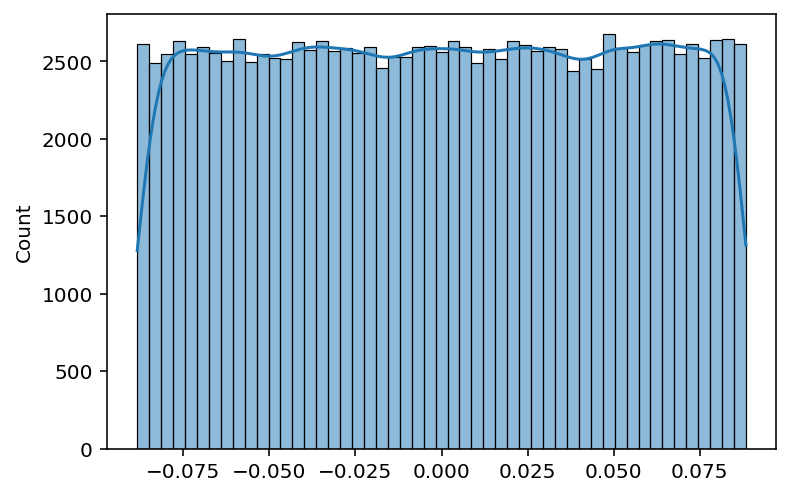

In [42]:
def xavier(inputs, neurons):
    """Xavier initialization"""
    limit = np.sqrt(6 / (inputs+neurons))
    weights = np.random.uniform(low=-limit, high=limit, size=(inputs, neurons))
    return weights

weights = xavier(512, 256)

hist = sns.histplot(weights.flatten(), stat="count", kde=True)
print(f"Minimum: {weights.min():.4f}   Maximum: {weights.max():.4f}")
print(f"Mean:    {weights.mean():.4f}   SD: {weights.std():.4f}")
hist.get_figure().savefig("assets/init_xavier.png", dpi=200, bbox_inches='tight')

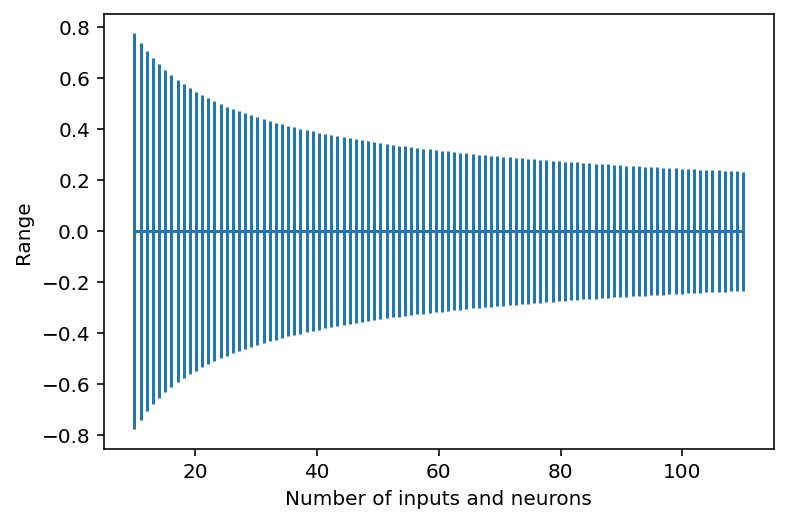

In [86]:
# The larger the number of inputs and neurons in a layer, the smaller the range of the weights
values = np.linspace(10, 110, num=100)
results = np.sqrt(6) / np.sqrt(values)
plt.errorbar(values, np.zeros(100), yerr=results)
plt.xlabel("Number of inputs and neurons")
plt.ylabel("Range")
plt.savefig("assets/init_xavier_range.png", dpi=200, bbox_inches='tight')
plt.show()

[He et al.](https://arxiv.org/abs/1502.01852) (2015) proposed a strategy tailored to networks using the ReLU activation function that, similarly to Xavier initialization, would mantain a stable activation variance throughout the network. Weights are initialized using a Gaussian probability distribution with a mean of 0.0 and a standard deviation of $\sqrt \frac{2}{n}$ where $n$ is the number of inputs to the neuron, while biases are initialized to zero. This method is now known as ***He initialization***.

Minimum: -0.2562   Maximum: 0.2892
Mean:    0.0001   SD: 0.0625


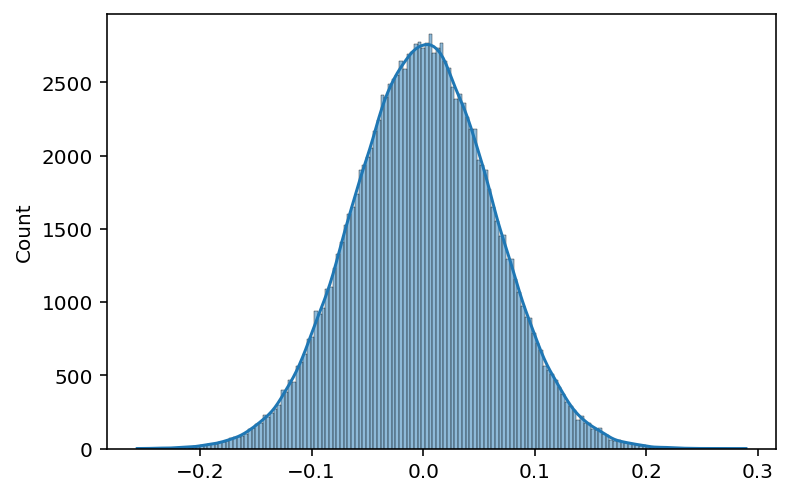

In [43]:
def he(inputs, neurons):
    """He initialization"""
    return np.random.randn(inputs, neurons) * np.sqrt(2.0 / inputs)

weights = he(512, 256)

hist = sns.histplot(weights.flatten(), stat="count", kde=True)
print(f"Minimum: {weights.min():.4f}   Maximum: {weights.max():.4f}")
print(f"Mean:    {weights.mean():.4f}   SD: {weights.std():.4f}")
hist.get_figure().savefig("assets/init_he.png", dpi=200, bbox_inches='tight')

#### Overfitting/Underfitting

The central challenge in machine learning is to perform well on new, *previously unseen* inputs. Machine learning models are optimized on a known set of data, but their merit depends on their ability to make reliable predictions on cases they were not trained on. This ability is called ***generalization***.

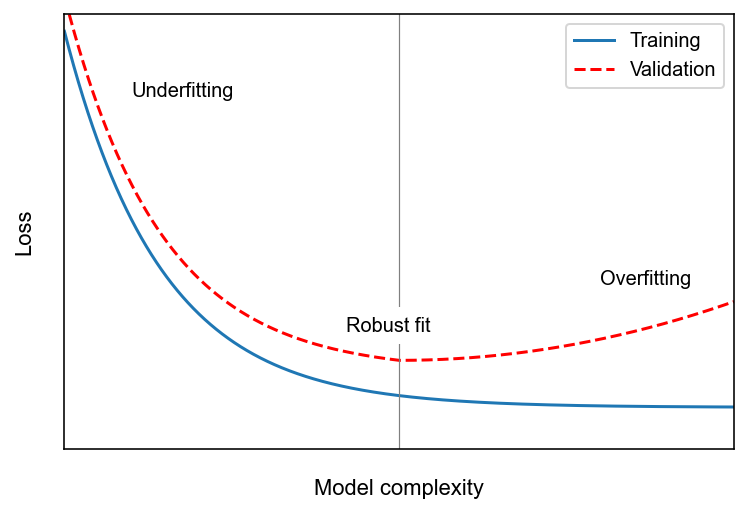

In [363]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = np.linspace(0, 10, 2000)

# Training curve
training = lambda x: 2**(-x+5) + 1.5
ax.plot(x, training(x), label="Training")
# Validation curve
validation = lambda x: 2**(-x+5) + 4.5 if x < 5 else (x-5)**2 / 5 + 5.5
ax.plot(x, [validation(x) for x in x], "r--", label="Validation")
# Horizontal line (robust fit)
ax.axvline(5, linewidth=0.6, color="grey")
# Text
ax.text(1, 28, "Underfitting", fontsize=10, fontfamily="Arial")
ax.text(8, 12, "Overfitting", fontsize=10, fontfamily="Arial")
ax.text(4.2, 8, "Robust fit", fontsize=10, backgroundcolor="w", fontfamily="Arial")
# Set x and y limits
ax.set_xlim(xmin=0, xmax=10)
ax.set_ylim(ymin=-2, ymax=35)
# Turn off tick labels
ax.set_xticks([])
ax.set_yticks([])
# Add labels and legend
ax.set_xlabel("Model complexity", fontsize=11, labelpad=15, fontfamily="Arial")
ax.set_ylabel("Loss", fontsize=11, labelpad=15, fontfamily="Arial")
plt.legend(prop={"size": 10, "family": "Arial"})
plt.savefig("assets/fit.png", dpi=200, bbox_inches='tight')
plt.show()

***Underfitting*** occurs when a model is unable to perform well on the training data. ***Overfitting*** occurs when it performs well on the training data, but does not generalize well. The reason behind this is that the model learns specific characteristics of the training data that are not general features. Specifically, the model's parameters become too adapted to the noise in the data and fail to capture its essential features. Overfitting can be adressed by regularizing the model.

## Regularization

"Regularization is any modiﬁcation we make to a learning algorithm that is intended to reduce its generalization error but not its training error" (Goodfellow et al, 2016, p. 120).

Limiting the representative capacity of the network and increasing noise are core strategies that underpin many regularization techniques. The capacity of a model can be limited by decreasing its size or by regularizing its weights. Noise can be injected at the input level through *dataset augmentation*, at the output level through *label smoothing*, or at the neuron level through *dropout*.

### Network size

The simplest regularization method is to reduce the size of the model (i.e. lower the total number of neurons). Reducing its size limits the capacity of the model and thus forces it to learn simpler representations. Unfortunatly, it is difficult to determine the right network size. In practice, the best model is therefore oftentimes "a large model that has been regularized appropriately" (ibid, p. 229). 

### Weight regularization

Large weights place a strong emphasis on a few features and lead to high gradients. ***Weight regularization*** constrains model complexity by forcing the weights to take on smaller values such that the distribution of weights values becomes more regular. This is achieved by adding to the loss function of the model a penalty associated with having large weights (Chollet, 2021, p. 146). The regularized loss $L_{reg}$ is given by:

$$L_{reg} = L + \lambda \Omega$$

where $L$ is the non-regularized loss, and $\Omega$ is the regularization penalty ($L^1$ or $L^2$). $\lambda$ is a hyperparameter that indicates the strenght of the preference for smaller weights. Minimizing a loss with weight regularization compels the model to choose weights that "make a tradeoff between fitting the training data and being small" (Goodfellow et al., 2016, p. 119).

$L^p$ spaces reminder: The $p$-norm or $L^p$-norm of a vector $x$ is defined by

$${\lVert x \rVert}_p = ({\lvert x_1 \rvert}^p + {\lvert x_2 \rvert}^p + ... + {\lvert x_n \rvert}^p)^\frac{1}{p}$$

for a real number $p ≥ 1$.

#### $L^1$ regularization

With $L^1$ regularization, the added penalty is given by the $L^1$ norm:

$$\Omega = {\left\lVert w \right\rVert}_1 = \sum_i{\lvert w_i \rvert}$$

The penalty is therefore *proportional to the absolute value of the weight coefficients*.

In [263]:
def l1_reg(w: np.ndarray):
    """L1 regularization"""
    return np.sum(np.absolute(w), axis=0)

# Small weights -> small penalty
w = np.array([[-0.15], [0.2], [-0.12], [0.04]])
l1_reg(w)

array([0.51])

In [264]:
# Large weights -> large penalty
w = np.array([[-1.5], [2], [-1.2], [0.4]])
l1_reg(w)

array([5.1])

In [265]:
# Alternative implementation using Numpy's buit-in `norm()` function
np.linalg.norm(w, ord=1, axis=0)

array([5.1])

#### $L^2$ regularization

With $L^2$ regularization (also known as ***weight decay*** in deep learning and as ridge regression or Tikhonov regularization in other fields of science) the added penalty is given by the squared $L^2$ norm:

$$\Omega = {\left\lVert w \right\rVert}_2^2 = w^Tw $$

and is therefore *proportional to the square of the value of the weight coefficients*.

In [25]:
def l2_reg(w: np.ndarray):
    """L2 regularization"""
    return np.sum(w**2, axis=0)

# Small weights -> small penalty
w = np.array([[-0.15], [0.2], [-0.12], [0.04]])
l2_reg(w)

array([0.0785])

In [18]:
# Large weights -> large penalty
w = np.array([[-1.5], [2], [-1.2], [0.4]])
l2_reg(w)

array([7.85])

In [262]:
# Implementation using Numpy's built-in `norm` function
np.linalg.norm(w, ord=2, axis=0)**2

array([7.85])

The derivative of the regularization penalty $\Omega = {\left\lVert w \right\rVert}_2^2$ with respect to the weight $w$ is $2w$. The partial derivative of the regularized loss function with respect to $w$ is thus:

$$\frac{\partial L_{reg}}{\partial w} = \frac{\partial L}{\partial w} + \lambda 2 w$$

When using gradient descent to optimize the regularized loss function, $\lambda 2 w$ can be factored out and reformulated as a fraction of the weight to be updated

$$w \leftarrow (1 - 2 \eta \lambda)w - \eta \frac{\partial L}{\partial w}$$

hence the name *weight decay*.

### Max-norm constraints

A ***max-norm constraint*** is another form of regularization that *limits the magnitude of the weights*. It is implemented by enforcing a limit $c$ on the weight vector $w$ of every neuron so that

$${\left\lVert w \right\rVert}_2 < c$$

Typical values for $c$ range between 1 and 4. If the weight vector exceeds the constraint, it is scaled down. Max-norm constraints are usually enforced after each parameter update.

In [ ]:
def max_norm(w: np.ndarray, c: float):
    """Enforces a max-norm constraint on the weight tensor"""
    norm = np.linalg.norm(w, axis=1)
    if norm > c:
        return w * (c / norm)
    return w

# Small weights do not exceed the constraint
max_norm(np.array([[-0.15, 0.2, -0.12, 0.04]]), c=2)

array([[-0.15,  0.2 , -0.12,  0.04]])

In [ ]:
# Large weights exceeding the constraint are normalized
w = max_norm(np.array([[-1.5, 2, -1.2, 0.4]]), c=2)
print(f"New norm: {np.linalg.norm(w, axis=1)}\n{w}")

New norm: [2.]
[[-1.07074592  1.42766122 -0.85659673  0.28553224]]


### Dropout

***Dropout*** is a technique that randomly drops neurons from the neural network during training and thus prevents them from "co-adapting too much" (Srivastava et al., 2014). By making the training process noisy, dropout increases the robustness of the trained model.

Dropout is implemented on a per-layer basis. A hyperparameter $p$ indicates the probability that a given neuron in a layer is dropped out. Since dropout is applied only during training, the activations must be scaled so that the expected activations during training equal the actual activations at test time.

In [74]:
def dropout(a: np.ndarray, p: float):
    """Inverted dropout: activations are scaled during training"""
    mask = (np.random.rand(*a.shape) < p) / p
    return a * mask

# Activations of a layer
activations = np.array([[0.12, 0.5, 0.345, 0.02, 0.69]])
# Dropout probability
p = 0.5

dropout(activations, p)

array([[0.  , 0.  , 0.69, 0.04, 0.  ]])

### Early Stopping

The loss of a large model tends to decrease steadily during training, but the validation error can rise again when the model starts overfitting. ***Early stopping*** is a strategy to return the parameters with the lowest validation error at the end of training. Early-stopping algorithms track the validation error during training and store the model parameters each time the error reaches a new low. Training is stopped when the best recorded error has not been beaten for a pre-determined number of iterations.

Early stopping is a form of hyperparameter selection for the optimal number of training steps. Compared to other forms of regularization, it is unobstrusive and is therefore widely used.

## Normalization

Normalization denotes a family of methods within the field of statistics that transform a set of a data to a specific scale. In deep learning, normalization is used to normalize the hidden states of a neural network. Normalization should not be confused with a *norm*, which is a function that maps a vector space to non-negative real numbers.

Stochastic gradient descent and its variants are intrisically tied to the distributions of gradients. The expected accuracy of the approximated gradient depends on the variance of these distributions, and shifts of their moments can lead to exploding or vanishing gradients.

Gradients are determined by the activations and eventual output of the neural network. Normalization attempts to reduce changes in the distributions of these activations (termed as *internal covariate shift*) by standardizing them. 

<div align="center">
    <img src="assets/norms.jpg" width=55% style="margin:20px" alt="Normalization methods"/>
</div>

Batch, layer, instance and group normalization are four methods commonly used for normalizing hidden states. Their main differentiator is the dimension along which they are applied. The figure above illustrates this difference. $N$ is the batch axis, $C$ the channel axis, and $(H, W)$ are the spatial axes, i.e. the height and width. In fully-connected neural networks, the channel axis represents the neurons in a layer, while the spatial axes have a size of 1. In convolutional neural networks, the channel axis represents the filters in a layer while the spatial axes correspond to the filter's height and width. Batch norm normalizes weighted sums across a mini-batch, while the other three methods operate on a single instance.

### Batch Norm

***Batch normalization*** (Ioffe and Szegedy, 2015) standardizes each hidden feature (neuron) using its mean and variance across a mini-batch. For a batch $\mathcal{B} = x_{1...m}$ with $m$ samples, we calculate the mean $\mu_{\mathcal{B}}$ and variance $\sigma_{\mathcal{B}}^2$ of each activation across the batch:

$$\mu_{\mathcal{B}} = \frac{1}{m} \sum_{i=1}^m x_i$$

$$\sigma_{\mathcal{B}}^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_{\mathcal{B}})^2 $$

The activations are then normalized based on their mean and variance across the mini-batch. Essentially, we calculate their standard score, or z-score. The normalized activations $\hat{x}_i$ are given by:

$$\hat{x}_i = \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^2 + \epsilon}}$$

where $\epsilon$ is a constant used for numerical stability. The distribution of values of any $\hat{x}$ has an expected value of $0$ and a variance of $1$.

Normalizing hidden units to have zero mean and unit variance restricts the representations that the model can learn. Batch normalization therefore introduces two learnable parameter vectors $\gamma$ and $\beta$ that shift and scale the normalized activations along the channel axis:

$$y_i = \gamma \hat{x}_i + \beta$$

Applying this linear transformation on the normalized activations effectively converts the mean and variance of the hidden units into known, learnable parameters.

During inference, the activations are normalized using a moving average of the mean and variance of the mini-batches it has seen during training. These are given by:

$$\mu_{new} = \alpha \mu + (1 - \alpha) \mu_t $$

$$\sigma^2_{new} = \alpha \sigma^2 + (1 - \alpha) \sigma^2_t $$

where $\mu$ and $\sigma^2$ are the running averages, $\mu_t$ and $\sigma^2_t$ are the new observed values, and $\alpha$ is a momentum parameter that is usually set to $0.9$ or $0.99$.

The implementation below is designed for 1D inputs (i.e. with spatial axes of size 1).

In [8]:
class BatchNorm():
    """Batch Normalization"""

    def __init__(self, C, momentum=0.99):
        self.gamma = np.ones(C)
        self.beta = np.zeros(C)
        self.avg_mean = np.zeros(C)
        self.avg_var = np.ones(C)
        self.alpha = momentum

    def forward(self, x, eps=1e-8, inference=False):
        # x: input with shape (N, C)
        if inference:
            x_hat = (x - self.avg_mean) / np.sqrt(self.avg_var + eps)
            y = self.gamma * x_hat + self.beta
            return y
        mean = x.mean(axis=0, keepdims=True)
        var = x.var(axis=0, keepdims=True)
        self.avg_mean = self.alpha * self.avg_mean + (1-self.alpha) * mean
        self.avg_var = self.alpha * self.avg_var + (1-self.alpha) * var
        x_hat = (x - mean) / np.sqrt(var + eps)
        y = self.gamma * x_hat + self.beta
        return y

x = np.array([
    [1.4, 0.62, 0.21], # Sample 1
    [-.2, 1.6, -1.35], # Sample 2
    [-.97, 1.3, -2.1]  # Sample 3
])
bn = BatchNorm(C=3)
y = bn.forward(x)
y

array([[ 1.34058903, -1.34963806,  1.34069849],
       [-0.28027428,  1.04068477, -0.28061131],
       [-1.06031475,  0.30895329, -1.06008718]])

In [9]:
print(f"Before BN:\n{'Mean':<11}{x.mean(axis=0)}\nVariance {x.var(axis=0)}")
print(f"After BN:\n{'Mean':<11}{y.mean(axis=0)}\nVariance {y.var(axis=0)}")

Before BN:
Mean       [ 0.07666667  1.17333333 -1.08      ]
Variance [0.97442222 0.16808889 0.9258    ]
After BN:
Mean       [ 0.00000000e+00 -4.99600361e-16  0.00000000e+00]
Variance [0.99999999 0.99999994 0.99999999]


Batch normalization is part of the computational graph of a network and we therefore need to backpropagate the loss through it and calculate the gradient of its parameters during training. The partial derivatives with respect to $\gamma$ and $\beta$ are given by:

$$
\frac{\partial L}{\partial \gamma} = \sum_{i=1}^m \frac{\partial L}{\partial y_i} \cdot \hat{x}_i
$$

$$
\frac{\partial L}{\partial \beta} = \sum_{i=1}^m \frac{\partial L}{\partial y_i}
$$

where $\partial L / \partial y$ is the loss of the ouput $y$ of the batch normalization layer. To backpropagate the loss to lower layers, we compute first the intermediate partial derivative $\partial L / \partial \hat{x}_i$:

$$
\frac{\partial L}{\partial \hat{x}_i }
=
\frac{\partial L}{\partial y_i} \cdot \gamma
$$

and then relate it to the input $x$:

$$
\frac{\partial L}{\partial x_i} = \frac{1}{m} \odot (\sigma^2 + \epsilon)^{-1/2}
\left[
    m
    \frac{\partial L}{\partial \hat{x}_i}
    - \sum_{j=1}^m \frac{\partial L}{\partial \hat{x}_j}
    - \hat{x}_i \sum_{j=1}^m \frac{\partial L}{\partial \hat{x}_j} \cdot \hat{x}_j
\right]

$$

<!-- The partial derivatives with respect to $\gamma$ and $\beta$ are given by:

$$
\frac{\partial \mathrm{BN}}{\partial \gamma} = \sum_{i=1}^m \frac{\partial L}{\partial y_i} \cdot \hat{x}_i
$$

$$
\frac{\partial \mathrm{BN}}{\partial \beta} = \sum_{i=1}^m \frac{\partial L}{\partial y_i}
$$

Using the chain rule, we can relate these partial derivatives to the loss $\partial L / \partial y$ of the ouput $y$ of the batch normalization layer by multiplying them with $\sum_i \partial L / \partial y_i$. To backpropagate the loss to lower layers, we compute $\partial L / \partial x$ -->

See Kevin Zakka's [blogpost](https://kevinzakka.github.io/2016/09/14/batch_normalization/) for a full derivation.

Batch normalization can considerably improve the performance of deep neural networks. It also reduces their sensitivity to hyperparamaters such as the learning rate and the initialization strategy. One of its drawbacks is that it requires sufficiently large batch sizes (e.g. 32) to work well. Small batch sizes result in inaccurate estimations of the mean and variance of the batch and can thus lead to a higher model error. Another downside is that it relies on statistics pre-computed from the training set to perform normalization at inference time. If the data distribution changes, this can lead to inconsistent results between training and testing.

### Layer Norm

***Layer normalization*** (Ba et al., 2016) standardizes all hidden features in a layer using their mean and variance for a single training sample. All the units in a layer therefore share the same normalization terms, but different training examples have different normalization terms.

Its implementation differs from that of batch normalization in two aspects: the mean $\mu$ and variance $\sigma^2$ are calculated along the layer dimension, and the moving averages thereof are dispensed off. Since layer normalization does not depend on batch statistics, there is no need to calculate running averages of the mean and variance for use at inference.

The implementation below is designed for 1D inputs.

In [481]:
class LayerNorm():
    """Layer Normalization"""

    def __init__(self, C):
        # C: number of channels
        self.gamma = np.ones(C)
        self.beta = np.zeros(C)

    def forward(self, x, eps=1e-8):
        # x: input with shape (N, C)
        mean = x.mean(axis=1, keepdims=True)
        var = x.var(axis=1, keepdims=True)
        x_hat = (x - mean) / np.sqrt(var + eps)
        y = self.gamma * x_hat + self.beta
        return y

ln = LayerNorm(C=3)
y = ln.forward(x)
y

array([[ 1.3304131 , -0.24987454, -1.08053856],
       [-0.17846774,  1.30418734, -1.1257196 ],
       [-0.26877674,  1.33681063, -1.06803389]])

In [10]:
print(f"Before LN:\n{'Mean':<11}{x.mean(axis=1)}\nVariance {x.var(axis=1)}")
print(f"After LN:\n{'Mean':<11}{y.mean(axis=1)}\nVariance {y.var(axis=1)}")

Before LN:
Mean       [ 0.74333333  0.01666667 -0.59      ]
Variance [0.24362222 1.47388889 1.99886667]
After LN:
Mean       [ 0.44388315  0.15993306 -0.60381621]
Variance [1.60835917 0.38786181 0.41657409]


Layer normalization is particularly effective for training sequential models (RNN/LSTM), whose inputs vary in length for different training examples.

### Instance Norm

***Instance normalization*** (Ulyanov et al., 2017) standardizes all hidden features in a layer using their mean and variance for a single training sample and for a single channel. In models such as convolutional neural networks, where each layer results in a 3D volume of activations (H x W x C), the activations of each channel are therefore normalized independently.

In [12]:
# Batch of activations with 4 channels
cnn = np.array([
    # Sample 1 (H x W x C -> 2 x 2 x 4)
    [[[0.43, 0.5, 0.2, 0.4], [0.8, 0.84, 0.5, 0.7]],
     [[0.1, 0.74, 0.8, 0.2], [0.42, 0.5, 0.8, 0.6]]],
    # Sample 2
    [[[0.97, 0.7, 0.3, 0.8], [0.7, 0.13, 0.9, 0.0]],
     [[0.5, 0.8, 0.17, 0.5], [0.1, 0.86, 0.7, 0.9]]],
])
cnn.shape

(2, 2, 2, 4)

Compared to layer normalization, the only theoretical difference of instance normalization is that it normalizes each channel independently.

The implementation below is adapted for 4D inputs.

In [13]:
class InstanceNorm():
    """Instance Normalization"""

    def __init__(self, C):
        # C: number of channels
        self.gamma = np.ones(C)
        self.beta = np.zeros(C)

    def forward(self, x, eps=1e-8):
        # x: input with shape (N, H, W, C)
        mean = x.mean(axis=(1, 2), keepdims=True)
        var = x.var(axis=(1, 2), keepdims=True)
        x_hat = (x - mean) / np.sqrt(var + eps)
        y = self.gamma * x_hat + self.beta
        return y

inn = InstanceNorm(C=4)
y = inn.forward(cnn)
y

array([[[[-0.03026291, -0.97153634, -1.5075566 , -0.39056668],
         [ 1.4627075 ,  1.30654887, -0.30151132,  1.17170004]],

        [[-1.36183112,  0.63652381,  0.90453396, -1.43207783],
         [-0.07061347, -0.97153634,  0.90453396,  0.65094447]]],


       [[[ 1.26858194,  0.26721158, -0.73773859,  0.71428569],
         [ 0.41760772, -1.69808648,  1.29740234, -1.57142851]],

        [[-0.21274356,  0.61200071, -1.17868579, -0.14285714],
         [-1.47344611,  0.81887419,  0.61902203,  0.99999996]]]])

In [14]:
print(f"Before IN:\n{'Mean':<11}{cnn.mean(axis=(1, 2))}\nVariance {cnn.var(axis=(1, 2))}")
print(f"After IN:\n{'Mean':<11}{y.mean(axis=(1, 2))}\nVariance {y.var(axis=(1, 2))}")

Before IN:
Mean       [[0.4375 0.645  0.575  0.475 ]
 [0.5675 0.6225 0.5175 0.55  ]]
Variance [[0.06141875 0.022275   0.061875   0.036875  ]
 [0.10066875 0.08411875 0.08691875 0.1225    ]]
After IN:
Mean       [[-6.93889390e-18 -1.66533454e-16  2.77555756e-16  5.55111512e-17]
 [-5.55111512e-17  1.94289029e-16  1.66533454e-16 -8.32667268e-17]]
Variance [[0.99999984 0.99999955 0.99999984 0.99999973]
 [0.9999999  0.99999988 0.99999988 0.99999992]]


Empirical evidence suggests that instance normalization works well as a replacement for batch normalization in GANs and for neural style transfer. 

### Group Norm

***Group normalization*** (Wu and He, 2018) is a generalization of single instance normalization methods to any group of channels. Layer normalization computes statistics across all channels, while instance normalization does so for each channel. Group normalization extends these methods to any division of the channels. Layer and instance normalization can therefore be seen as specific cases of group normalization.

The motivation behind group normalization is that features such as the filters of convolutional neural networks are group-wise representations (i.e. they are interrelated) and should therefore be normalized as such.

In [15]:
class GroupNorm():
    """Group Normalization"""

    def __init__(self, C):
        # C: number of channels
        self.gamma = np.ones(C)
        self.beta = np.zeros(C)

    def forward(self, x, G, eps=1e-8):
        # x: input with shape (N, H, W, C)
        # G: number of groups
        N, H, W, C = x.shape
        x = x.reshape(N, H, W, G, C // G)
        mean = x.mean(axis=(1, 2, 4), keepdims=True)
        var = x.var(axis=(1, 2, 4), keepdims=True)
        x_hat = (x - mean) / np.sqrt(var + eps)
        x_hat = x_hat.reshape(N, H, W, C)
        y = self.gamma * x_hat + self.beta
        return y

gn = GroupNorm(C=4)
y = gn.forward(cnn, G=2)
y

array([[[[-0.48502258, -0.17983983, -1.42693524, -0.54882125],
         [ 1.12808623,  1.30247637, -0.10976425,  0.76834975]],

        [[-1.92374125,  0.86650101,  1.20740674, -1.42693524],
         [-0.52862012, -0.17983983,  1.20740674,  0.32929275]]],


       [[[ 1.2286829 ,  0.34403121, -0.72145939,  0.82176925],
         [ 0.34403121, -1.5235668 ,  1.13041498, -1.64739657]],

        [[-0.31126634,  0.67167999, -1.12269883, -0.10416793],
         [-1.62186143,  0.86826925,  0.51312352,  1.13041498]]]])

In [16]:
eval_cnn = cnn.reshape((2, 2, 2, 2, 2))
eval_y = y.reshape((2, 2, 2, 2, 2))

print(f"Before GN:\n{'Mean':<11}{eval_cnn.mean(axis=(1, 2, 4))}\nVariance {eval_cnn.var(axis=(1, 2, 4))}")
print(f"After GN:\n{'Mean':<11}{eval_y.mean(axis=(1, 2, 4))}\nVariance {eval_y.var(axis=(1, 2, 4))}")

Before GN:
Mean       [[0.54125 0.525  ]
 [0.595   0.53375]]
Variance [[0.05261094 0.051875  ]
 [0.09315    0.10497344]]
After GN:
Mean       [[-1.11022302e-16  4.44089210e-16]
 [ 8.32667268e-17  2.22044605e-16]]
Variance [[0.99999981 0.99999981]
 [0.99999989 0.9999999 ]]


Wu and He (2018) report that group normalization achieves better results than batch normalization in ResNets with low batch sizes, and similar results when using normal batch sizes.

## Assembling the Building Blocks Together

### MNIST

The MNIST dataset, assembled by [LeCun et al. (1998a)](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf), is a collection of binary images of handwritten digits. The digits are size-normalized and centered in images of size 28x28. The dataset comprises of a training set of 60,000 samples, a test set of 10,000 samples, and their corresponding labels.

MNIST is a classic dataset in machine learning, and is often used in introductions to the field owing to its simplicity and the ease of training different classifiers on it.

In [49]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

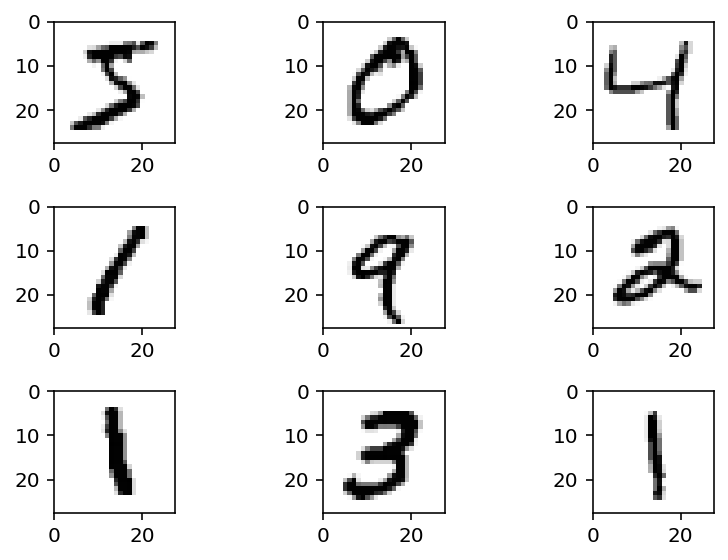

In [58]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    digit = X_train[i]
    plt.imshow(digit, cmap="binary")
    plt.xlim(xmin=0)
    plt.ylim(ymax=0)
plt.tight_layout()
plt.savefig("assets/mnist.png", dpi=200, bbox_inches='tight')
plt.show()

The images have a grayscale ranging from 0 to 255. We rescale these so that all values range between 0 and 1.

In [34]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

Since we'll train fully-connected neural networks, we flatten each image into a single dimension.

In [35]:
X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

Next, the labels are encoded as ***one-hot encoded vectors*** to match the output of the neural network.

In [36]:
def onehot(y):
    """Encodes the expected result as a one-hot vector"""
    v = np.zeros((y.size, y.max()+1))
    v[np.arange(y.size), y] = 1
    return v

# Example
onehot(np.array([5, 0, 9]))

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [38]:
y_train = onehot(y_train)
y_test = onehot(y_test)

Our neural network consists of single hidden layer with 600 units and ReLU activations followed by an output layer with 10 units and softmax activation. The loss is given by the cross-entropy loss function. We also apply weight decay (L2 normalization) to the weights of the hidden and output layer.

For the backward pass, we backpropagate the loss through the loss function and output layer by taking the partial derivative of the cross-entropy function with respect to the weighted sum $z$ of the output layer. Since the output of the network $\hat{y}$ is given by $softmax(z)$ and the loss $L$ by $CE(y, \hat{y})$:

$$\frac{\partial L}{\partial z} = \hat{y} - y$$

In [44]:
class NeuralNetwork:

    def __init__(self):
        # Input layer: 784 inputs
        # Hidden layer: 600 neurons
        self.w1 = he(inputs=784, neurons=600)
        self.b1 = np.zeros((1, 600))
        # Output layer: 10 neurons
        self.w2 = xavier(inputs=600, neurons=10)
        self.b2 = np.zeros((1, 10))

    def forward(self, x):
        """Forward pass"""
        a1 = relu(x @ self.w1 + self.b1)
        pred = softmax(a1 @ self.w2 + self.b2)
        return pred

    def backprop(self, X, y, lmbda):
        """Compute gradient over the batch through backpropagation

        Inputs:
            - X: batch of inputs
            - y: batch of labels
            - lmbda: weight decay parameter
        """
        # Forward pass, caching intermediate values
        z1 = X @ self.w1 + self.b1
        a1 = relu(z1)
        z2 = a1 @ self.w2 + self.b2
        pred = softmax(z2)
        # Cross-entropy loss with L2 regularization
        loss = cross_entropy(y, pred)
        loss += lmbda * (np.sum(self.w1**2) + np.sum(self.w2**2))

        # Backward pass
        dL_dz2 = pred - y
        dL_dw2 = a1.T @ dL_dz2 / len(X)
        dL_db2 = np.mean(dL_dz2, axis=0, keepdims=True)
        dL_da1 = dL_dz2 @ self.w2.T
        dL_dz1 = dL_da1 * relu(z1, derivative=True)
        dL_dw1 = X.T @ dL_dz1 / len(X)
        dL_db1 = np.mean(dL_dz1, axis=0, keepdims=True)
        return loss, (dL_dw1, dL_dw2, dL_db1, dL_db2)

    def evaluate(self, X, y):
        """Evaluate the accuracy of the model"""
        preds = model.forward(X)
        acc = sum(np.argmax(preds, axis=1) == np.argmax(y, axis=1)) / len(y)
        return acc

The model is trained using mini-batch SGD. Weight decay is applied at each update.

In [45]:
np.random.seed(2022)
model = NeuralNetwork()
epochs = 25
lr = 0.02
batch_size = 16
lmbda = 2e-4

losses = []
train_accuracy = [model.evaluate(X_train, y_train)]
test_accuracy = [model.evaluate(X_test, y_test)]
for epoch in range(epochs):
    X_train, y_train = shuffle(X_train, y_train)
    for i in range(0, len(X_train), batch_size):
        X = X_train[i:i+batch_size]
        y = y_train[i:i+batch_size]
        loss, grads = model.backprop(X, y, lmbda)
        dL_dw1, dL_dw2, dL_db1, dL_db2 = grads
        model.w1 -= lr * (dL_dw1 + 2 * lmbda * model.w1)
        model.b1 -= lr * dL_db1
        model.w2 -= lr * (dL_dw2 + 2 * lmbda * model.w2)
        model.b2 -= lr * dL_db2
        if i % 750 == 0:
            losses.append(loss.item())
            train_accuracy.append(model.evaluate(X_train, y_train))
            test_accuracy.append(model.evaluate(X_test, y_test))
    if epoch % 2 == 0:
        train_acc = model.evaluate(X_train, y_train)
        test_acc = model.evaluate(X_test, y_test)
        print(f"loss: {loss:.4f} train acc.: {train_acc:.4f} test acc.: {test_acc:.4f} [{epoch+1:>2d}/{epochs}]")

loss: 0.7563 train acc.: 0.9346 test acc.: 0.9342 [ 1/25]
loss: 0.2384 train acc.: 0.9626 test acc.: 0.9586 [ 3/25]
loss: 0.4797 train acc.: 0.9740 test acc.: 0.9686 [ 5/25]
loss: 0.2492 train acc.: 0.9805 test acc.: 0.9734 [ 7/25]
loss: 0.2081 train acc.: 0.9839 test acc.: 0.9757 [ 9/25]
loss: 0.1762 train acc.: 0.9864 test acc.: 0.9771 [11/25]
loss: 0.1604 train acc.: 0.9886 test acc.: 0.9783 [13/25]
loss: 0.1501 train acc.: 0.9901 test acc.: 0.9803 [15/25]
loss: 0.2813 train acc.: 0.9909 test acc.: 0.9799 [17/25]
loss: 0.1618 train acc.: 0.9923 test acc.: 0.9802 [19/25]
loss: 0.1423 train acc.: 0.9930 test acc.: 0.9804 [21/25]
loss: 0.1826 train acc.: 0.9939 test acc.: 0.9811 [23/25]
loss: 0.2321 train acc.: 0.9943 test acc.: 0.9815 [25/25]


The model achieves a test error of 1.85%, in line with other fully-connected neural networks of similar size. Despite L2 regularization, the training and test accuracy differ by 1.28%, indicating that the model slightly overfits on the training set.

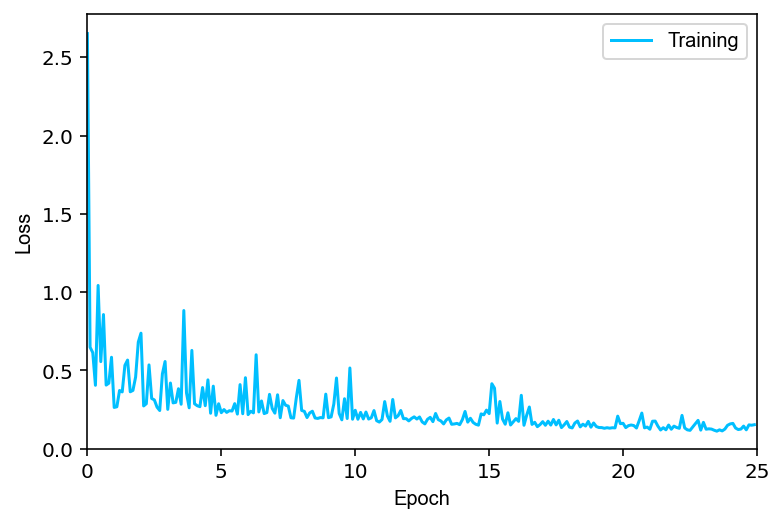

In [46]:
plt.plot(np.linspace(0, 24.9, 250), losses, c="deepskyblue", label="Training")
plt.xlim(xmin=0, xmax=epochs)
plt.ylim(ymin=0)
plt.xlabel("Epoch", fontfamily="Arial")
plt.ylabel("Loss", fontfamily="Arial")
plt.legend(prop={"size": 10, "family": "Arial"})
plt.savefig("assets/mnist_loss.png", dpi=200, bbox_inches='tight')
plt.show()

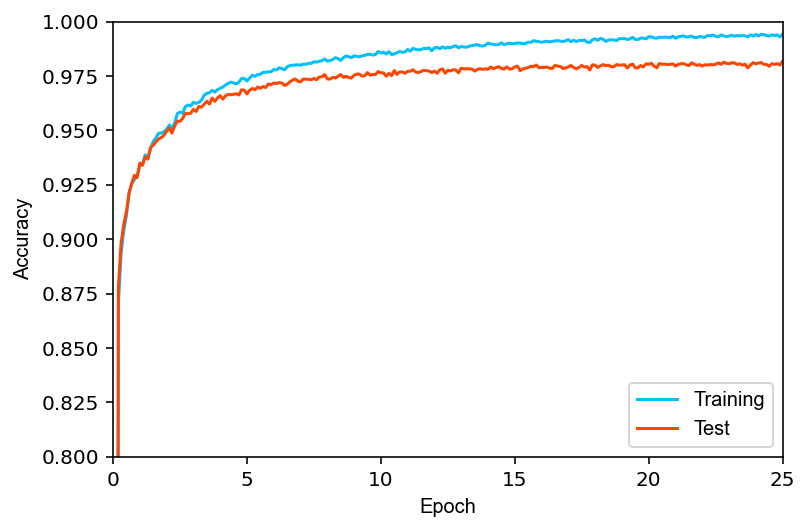

In [47]:
intervals = np.linspace(0, 25, 251)
plt.plot(intervals, train_accuracy, c="deepskyblue", label="Training")
plt.plot(intervals, test_accuracy, c="orangered", label="Test")
plt.xlim(xmin=0, xmax=epochs)
plt.ylim(ymin=0.8, ymax=1)
plt.xlabel("Epoch", fontfamily="Arial")
plt.ylabel("Accuracy", fontfamily="Arial")
plt.legend(loc="lower right", prop={"size": 10, "family": "Arial"})
plt.savefig("assets/mnist_acc.png", dpi=200, bbox_inches='tight')
plt.show()

We can also evaluate the model by plotting its predictions on the test set with a confusion matrix. As can be seen below, digits such as 0, 1 and 3 are seldom misclassified while other such 8 and 9 are misclassified more frequently. The model particularly struggles with distinguishing between 4 and 9, and between 2 and 7.

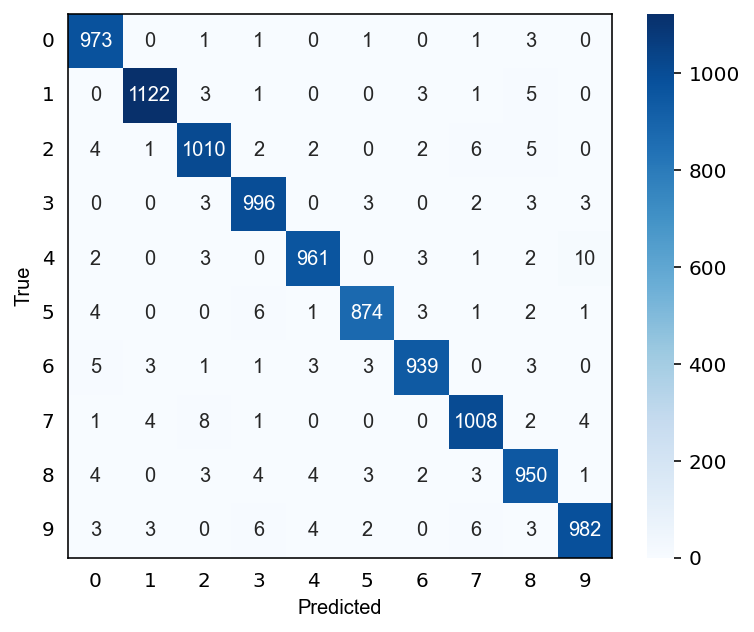

In [48]:
preds = model.forward(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6.35, 5))
sns.heatmap(cm, ax=ax, annot=True, cbar=True, square=True, cmap="Blues", fmt="d", annot_kws={"size": 10, "fontfamily": "Arial"})
for _, spine in ax.spines.items():
    spine.set_visible(True)
labels = np.arange(10)
ticks = np.linspace(0.5, 9.5, 10)
ax.set_xticks(ticks, labels)
ax.set_yticks(ticks, labels, rotation=360)
ax.tick_params(width=0)
ax.set_xlabel("Predicted", fontfamily="Arial")
ax.set_ylabel("True", fontfamily="Arial")
plt.savefig("assets/mnist_cm.png", dpi=200, bbox_inches='tight')
plt.show()

### Pytorch

In [10]:
class PytorchNeuralNetwork(nn.Module):

    def __init__(self):
        super(PytorchNeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 600),
            nn.ReLU(),
            nn.Linear(600, 10)
        )

    def forward(self, x):
        pred = self.layers(x)
        return pred

    def evaluate(self, x, y):
        preds = model.forward(x)
        acc = sum(torch.argmax(preds, 1) == torch.argmax(y, 1)) / len(y)
        return acc

Pytorch provides two primitives for handling data: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. `Dataset` stores the samples and their corresponding labels while `DataLoader` provides an iterable over a dataset.

First, we convert the data into torch tensors.

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

X_train.shape

torch.Size([60000, 784])

Next, we load the training data into `TensorDataset`, a subclass of `Dataset`, and wrap it with `DataLoader`.

In [12]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [15]:
torch.manual_seed(2022)
model = PytorchNeuralNetwork().to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)
epochs = 30

losses = []
train_accuracy = [model.evaluate(X_train, y_train)]
test_accuracy = [model.evaluate(X_test, y_test)]
# Training loop
for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        pred = model.forward(inputs)
        loss = loss_fn(pred, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 375 == 0:
            losses.append(loss.item())
            train_accuracy.append(model.evaluate(X_train, y_train))
            test_accuracy.append(model.evaluate(X_test, y_test))
    if (epoch+1) % 2 == 0:
        train_acc = model.evaluate(X_train, y_train)
        test_acc = model.evaluate(X_test, y_test)
        print(f"loss: {loss.data:.4f} train acc.: {train_acc:.4f} test acc.: {test_acc:.4f} [{epoch+1:>2d}/{epochs}]")

loss: 0.1298 train acc.: 0.9578 test acc.: 0.9546 [ 2/30]
loss: 0.0853 train acc.: 0.9711 test acc.: 0.9668 [ 4/30]
loss: 0.0920 train acc.: 0.9783 test acc.: 0.9716 [ 6/30]
loss: 0.0307 train acc.: 0.9812 test acc.: 0.9754 [ 8/30]
loss: 0.0546 train acc.: 0.9815 test acc.: 0.9739 [10/30]
loss: 0.1141 train acc.: 0.9845 test acc.: 0.9782 [12/30]
loss: 0.0280 train acc.: 0.9840 test acc.: 0.9777 [14/30]
loss: 0.1350 train acc.: 0.9845 test acc.: 0.9772 [16/30]
loss: 0.1357 train acc.: 0.9837 test acc.: 0.9760 [18/30]
loss: 0.2754 train acc.: 0.9851 test acc.: 0.9768 [20/30]
loss: 0.0129 train acc.: 0.9868 test acc.: 0.9792 [22/30]
loss: 0.0308 train acc.: 0.9866 test acc.: 0.9772 [24/30]
loss: 0.0408 train acc.: 0.9842 test acc.: 0.9769 [26/30]
loss: 0.0939 train acc.: 0.9868 test acc.: 0.9791 [28/30]
loss: 0.1069 train acc.: 0.9853 test acc.: 0.9769 [30/30]


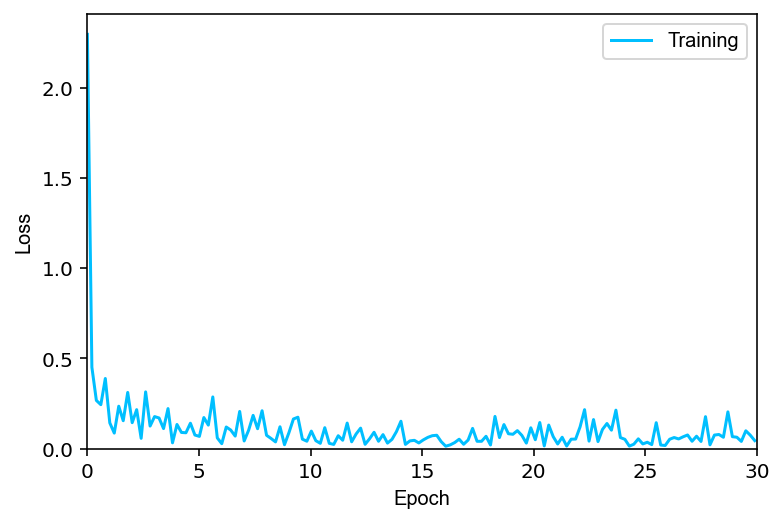

In [30]:
plt.plot(np.linspace(0, 29.9, 150), losses, c="deepskyblue", label="Training")
plt.xlim(xmin=0, xmax=epochs)
plt.ylim(ymin=0)
plt.xlabel("Epoch", fontfamily="Arial")
plt.ylabel("Loss", fontfamily="Arial")
plt.legend(prop={"size": 10, "family": "Arial"})
plt.savefig("assets/mnist_loss_pytorch.png", dpi=200, bbox_inches='tight')
plt.show()

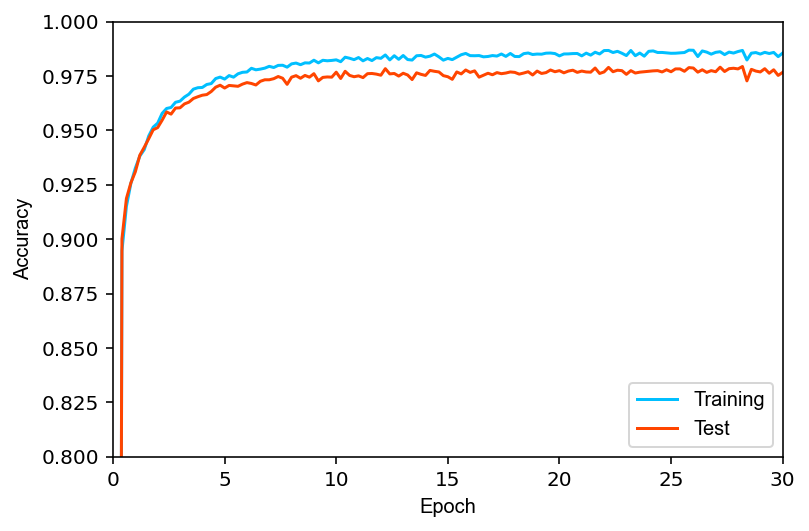

In [31]:
intervals = np.linspace(0, 30, 151)
plt.plot(intervals, train_accuracy, c="deepskyblue", label="Training")
plt.plot(intervals, test_accuracy, c="orangered", label="Test")
plt.xlim(xmin=0, xmax=epochs)
plt.ylim(ymin=0.8, ymax=1)
plt.xlabel("Epoch", fontfamily="Arial")
plt.ylabel("Accuracy", fontfamily="Arial")
plt.legend(loc="lower right", prop={"size": 10, "family": "Arial"})
plt.savefig("assets/mnist_acc_pytorch.png", dpi=200, bbox_inches='tight')
plt.show()